# Project 3: Web APIs & NLP
by Ethan Leow


<div>
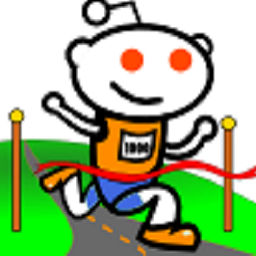
</div>

r/Ultramarathons: "Any idiot can run a marathon. It takes a special kind of idiot to run an ultramarathon."

r/ultrarunning: "Sometimes a marathon isn't far enough"



## Problem statement

I am a newbie to the marathon scene, having completed my first StanChart marathon virtually when the country was locked down during Covid-19 last year. I am itching to do my first ultramarathon (defined as any run beyond 42.195km) and have prepared a series of posts to ask running veterans for training advice. I found two of the most popular reddit communities for the ultra-running community to be r/Ultramarathon and r/ultrarunning. These are some of their attributes:

|subreddit|Date Created|Number of Members|Members Online (at time of checking)|
|---------|------------|-----------------|------------------------------------|
|r\Ultramarathon|Apr 25, 2010|57,000|18 (on 25 Sep, 1500h, SG time)|
|r\ultrarunning|Feb 4, 2012|45,700|40 (on 25 Sep, 1500h, SG time)|

Both communities look quite similar in size. r\Ultramarathon has 25% more members than r\ultrarunning, but the latter has more than twice the number of online (active) members than the former when I checked in at 3pm on 25 Sep. I want to find out where my posts would naturally belong to and elicit the most helpful comments. Their community descriptions are not helpful:
- r/Ultramarathon: Ultramarathon training, race reports, tips, tricks and overall discussion for crazy people who like ultrarunning.
- r/AdvancedRunning: Welcome to ultrarunning.

A quick scan of their recent posts is also not very helpful. Both communities have a lot of posts about how to train for 50k and beyond, as well as other miscellaneous items such as race reports. It is time to deploy my data science skills to come up with an algorithm to decide which running community most suited for my questions...

## Executive summary

Describe both subreddits, e.g. # of users, activity frequency

## Import Libraries

In [1]:
# Import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib_venn import venn2
import seaborn as sns

# Import time- and API- related libraries
import time, requests
from datetime import datetime

# Import warnings to remove flags when project is complete
import warnings
warnings.filterwarnings('ignore')

# Import pre-processing libraries
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from bs4 import BeautifulSoup
import re
# from wordcloud import WordCloud ## Can't seem to install wordcloud, remember to try again at end of project
# from PIL import Image

# Import vectorizing libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Import modelling-related libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix

# Set viewing parameters
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

## Scrap reddit

### Create scrapper function

In [2]:
# Create scrapper function

def scrape_subreddit(subreddit, numberofposts = 1_000):
    # Define pushshift's base URL
    url = 'https://api.pushshift.io/reddit/search/submission'
    
    # Define columns i want to keep
    to_keep = ['subreddit','author','title','selftext','created_utc']
    
    # Set current time in UTC timestamp format
    df_time = int(datetime.timestamp(datetime.utcnow()))
    
    # Create empty dataframe for concating loop later on
    df = pd.DataFrame(columns = to_keep)
    df_length = len(df)
    
    # Create dataframe of posts
    while df_length < numberofposts:

        # Set params
        params = {
            'subreddit' : subreddit,
            'size' : 100,
            'before' : df_time
        }

        # Get request from pushshift.io, return error message if it is not from 200 series
#         res = requests.get(url, params)
        try:
            res = requests.get(url, params)

            # Return error message if it's not 2xx
            if (res.status_code // 100) != 2:
                return "Hey dude, error! Unexpected response {}".format(res)

        except res.exceptions.RequestException as e:
            # A serious problem happened, like an SSLError or InvalidURL
            return "Yo, this is a very terrible error: {}".format(e)
        
        
        # Concat relevant .json data into dataframe
        df = pd.concat([
            df,
            pd.DataFrame(res.json()['data'])[to_keep]
        ], 
            axis = 0
        )
        
        # Clean data
        ##  1. drop empty posts
        df = df.loc[
            ((df['selftext'] != '') & (df['selftext'] != '[removed]')),
            :
        ].sort_values('created_utc', ascending = False)
        ##  2. drop duplicates by author with same text
        df = df.drop_duplicates(subset=['selftext', 'author'], keep = 'first').reset_index(drop=True)
        ##  3. drop nulls, especially true for selftext column
        df.dropna(inplace = True)
        
        # Find earliest-dated post in dataframe
        df_time = df['created_utc'].min()
#         print(f"min time is {df_time}.")
        
        # Find current length of dataframe (
        df_length = len(df)
        print(f"df for r\\{subreddit} has {df_length} posts now.")
       
        # Be a good citizen of scrapping world, don't overload pushshift server 
        # Sleep between 1-3 seconds
        time.sleep(1 + np.random.rand() * 2)
        
    return df[:numberofposts]
    
    

Describe scrapper function:
- Arguments to feed in are (subreddit, numberofposts)
    - "subreddit" is the name of the target subreddit
    - "numberofposts" is the number of good-quality reddit posts to extract (default value is set at 1_000)
- Set size at 100 for each request for posts
- Dropping bad-quality posts:
    - I notice about 20% of the posts are pictures or videos of people running, with nothing written, i.e. '' in the 'selftext', so those are dropped
    - There are a small number of np.nan posts, those are removed
    - A number of posts seem to be advertisements, they are labeled "[removed]" in the 'selftext' columns, so those are dropped
    - I remove reposts by the same author just in case they are posted more than once
- I set a random sleep time of between 1 to 2 seconds to avoid getting blacklisted by server for repeat requests

### Scrap scrap scrap

> Do not run this section to save time. Jump straight to Section 5.1 to download saved .csv files. Typically takes about 3-10 minutes for me to run, depending on internet connection

To extract 1,500 good-quality posts from each subreddit community. Chosen subreddits are:
- r\Ultramarathon
- r\AdvancedRunning

In [3]:
%%time
# Do not run this section to save time. Jump straight to Section 5.1 to download saved .csv files
# Typically takes about 3-10 minutes for me to run, depending on internet connection

# set scrape parameters
subreddit1 = 'Ultramarathon'
subreddit2 = 'ultrarunning'
posts = 1_500

# scrape from subreddits
df1 = scrape_subreddit(subreddit1, posts)
df2 = scrape_subreddit(subreddit2, posts)

df for r\Ultramarathon has 74 posts now.
df for r\Ultramarathon has 148 posts now.
df for r\Ultramarathon has 219 posts now.
df for r\Ultramarathon has 287 posts now.
df for r\Ultramarathon has 359 posts now.
df for r\Ultramarathon has 433 posts now.
df for r\Ultramarathon has 505 posts now.
df for r\Ultramarathon has 583 posts now.
df for r\Ultramarathon has 665 posts now.
df for r\Ultramarathon has 724 posts now.
df for r\Ultramarathon has 790 posts now.
df for r\Ultramarathon has 855 posts now.
df for r\Ultramarathon has 928 posts now.
df for r\Ultramarathon has 999 posts now.
df for r\Ultramarathon has 1066 posts now.
df for r\Ultramarathon has 1136 posts now.
df for r\Ultramarathon has 1211 posts now.
df for r\Ultramarathon has 1281 posts now.
df for r\Ultramarathon has 1350 posts now.
df for r\Ultramarathon has 1414 posts now.
df for r\Ultramarathon has 1467 posts now.
df for r\Ultramarathon has 1521 posts now.
df for r\ultrarunning has 80 posts now.
df for r\ultrarunning has 160

In [4]:
df1

,subreddit,author,title,selftext,created_utc
0,Ultramarathon,tizawer,MCM 50k Sale,Purchased registration for the Marine Corps Ma...,1632537589
1,Ultramarathon,lazysl0b,What’s your baseline MPW and schedule?,I’ve done a couple of ultras now and want to b...,1632472993
2,Ultramarathon,ultracrockett,Spartathlon,Spartathlon (246 km/153 miles) starts tomorrow...,1632428494
3,Ultramarathon,laflame1738,Advice before my first ultra,I am a D3 runner who is finishing up there las...,1632405780
4,Ultramarathon,ghostbrainalpha,Who is in better shape for a 100 mile race?,Neither person is remotely close to being capa...,1632332323
...,...,...,...,...,...
1495,Ultramarathon,kmjuniormint5,(Ultra)Running Media that I have gathered over...,Let's do this thing! Round 3 of videos from 20...,1481238619
1496,Ultramarathon,Simco_,Western States lottery: 2.2% chance counting a...,"&gt; A total of 4,248 runners entered the lott...",1480984499
1497,Ultramarathon,felsea62,Weekly vertical gain goal,What would be a good ballpark weekly vertical ...,1479471150
1498,Ultramarathon,a_bearded_man,Finished my first Ultra - 50 miles in the bag!,I just became an official ultramarathoner befo...,1479411289


In [5]:
df2

,subreddit,author,title,selftext,created_utc
0,ultrarunning,4EverPizza,SOCAL RUNNERS,Cucamonga Peak via ice house canyons\n\nStrenu...,1632621087
1,ultrarunning,Pro_Noobius,Sodium replacements,I’m new to the world of ultra. I have my first...,1632542512
2,ultrarunning,DoorPale6084,I need compression short recommendations,A phone pocket is a plus but not essential. I ...,1632537538
3,ultrarunning,BoulderTrailJunkie,Recovering from traumatic knee bursitis,"Hi all, I’m an avid runner/ hiker and fell las...",1632529624
4,ultrarunning,Unda_Da_Sea,Can rowing supplement running?,Looking for advice from this community. I have...,1632529469
...,...,...,...,...,...
1495,ultrarunning,Redhawkgirl,Does anyone else struggle with carb intake?,I know the science and I need to eat more carb...,1597639225
1496,ultrarunning,veggie-burrito,Should minutes per mile/km increase/decrease a...,"Hey friends! So, I'm slowly upping my mileage,...",1597618387
1497,ultrarunning,Scrubfire,I did my first 100k yesterday,"All my races were cancelled this year, includi...",1597594443
1498,ultrarunning,local_boy,Dan Lawson - New LEJOG FKT,In the early hours of this morning Dan Lawson ...,1597573708


### Save files to .csv

In [6]:
# Check for nan
print(f"# of Nulls for df1 \n {df1.isnull().sum()}")
print(f"# of Nulls for df2 \n {df2.isnull().sum()}")

# of Nulls for df1 
 subreddit      0
author         0
title          0
selftext       0
created_utc    0
dtype: int64
# of Nulls for df2 
 subreddit      0
author         0
title          0
selftext       0
created_utc    0
dtype: int64


In [7]:
# Check files that have empty posts or that are '[removed]' by reddit

In [8]:
df1.loc[((df1.selftext == '[removed]') | (df1.selftext == '')), :]

,subreddit,author,title,selftext,created_utc


In [9]:
df2.loc[((df1.selftext == '[removed]') | (df2.selftext == '')), :]

,subreddit,author,title,selftext,created_utc


In [10]:
# Check for reposts
df1.duplicated().sum(), df2.duplicated().sum()

(0, 0)

In [11]:
# Save files
df1.to_csv('../data/df1.csv', index = False)
df2.to_csv('../data/df2.csv', index = False)

## EDA and pre-processing

### Load data

In [88]:
df1 = pd.read_csv('../data/df1.csv')
df2 = pd.read_csv('../data/df2.csv')

In [89]:
df1.shape, df2.shape

((1500, 5), (1500, 5))

### Check authors
The intent is to look for very prolific authors who might post so much to a subreddit community that a classification model might just innocently fit to a very small group of authors' writing style. 

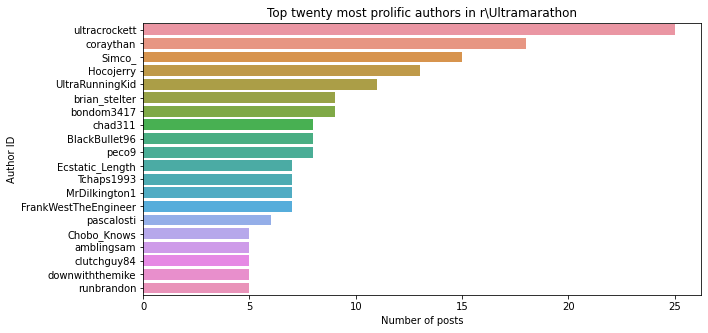

In [90]:
# Rank authors by posts
authors = df1.groupby("author")['selftext'].count().sort_values(ascending = False).head(20)

plt.figure(figsize=(10,5))
ax = sns.barplot(x = authors.values, y = authors.index)
ax.set_title(f"Top twenty most prolific authors in r\\{subreddit1}")
ax.set_xlabel("Number of posts")
ax.set_ylabel("Author ID");

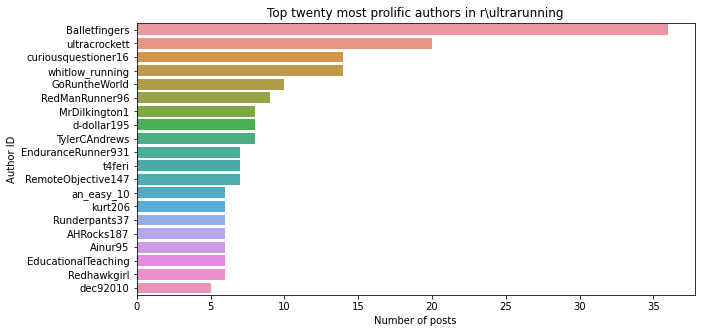

In [91]:
authors = df2.groupby("author")['selftext'].count().sort_values(ascending = False).head(20)

plt.figure(figsize=(10,5))
ax = sns.barplot(x = authors.values, y = authors.index)
ax.set_title(f"Top twenty most prolific authors in r\\{subreddit2}")
ax.set_xlabel("Number of posts")
ax.set_ylabel("Author ID");

It looks like there is no issue with overly-prolific authors on both subreddits. The author with the highest number of posts on r\Ultramarathon is ultracrockett with 25 posts and the author with the highest on r\ultrarunning is Balletfingers with 36 posts. They make up <=3% of their sample sets respectively. 

* However, I notice that ultracrockett is the second largest contributor on r\ultrarunning. This might pose a bit of problem during the modeling stage, as his posts might cause high correlation between the two subreddits. As a robustness check, I will remove his posts at the end of the project to see if its makes a material difference in predictive accuracy.

In [92]:
# Check posts written by AutoModerator
# pd.set_option('display.max_colwidth', None) #Expand Pandas' column width to show full thread content 
# df2[df2['author'] == "AutoModerator"]

[Only relevant if i pick r\\AdvanceRunning]: It looks like 'AutoModerator' is a bot that automatically generates posts to keep readers interested or engaged on events happening in the running world. I shall drop its posts since we are interested in analysing human-generated posts only. These posts make up <0.5% of the sample set.

In [93]:
# # Drop AutoModerator
# df1 = df1[df1['author'] != "AutoModerator"]
# df2 = df2[df2['author'] != "AutoModerator"]

In [94]:
# # Check
# df1[df1['author'] == "AutoModerator"], df2[df2['author'] == "AutoModerator"]

### Check dates

In [95]:
# Check time range of df1
print(f"The start date of df1 is {datetime.fromtimestamp(df1.created_utc.min())}.")
print(f"The end date of df1 is {datetime.fromtimestamp(df1.created_utc.max())}.")

The start date of df1 is 2016-11-14 22:04:29.
The end date of df1 is 2021-09-25 10:39:49.


In [96]:
# Check time range of df2
print(f"The start date of df2 is {datetime.fromtimestamp(df2.created_utc.min())}.")
print(f"The end date of df2 is {datetime.fromtimestamp(df2.created_utc.max())}.")

The start date of df2 is 2020-08-16 16:41:23.
The end date of df2 is 2021-09-26 09:51:27.


r\Ultramarathon has a wider date range than r\ultrarunning. Let's check the distribution of their post dates.

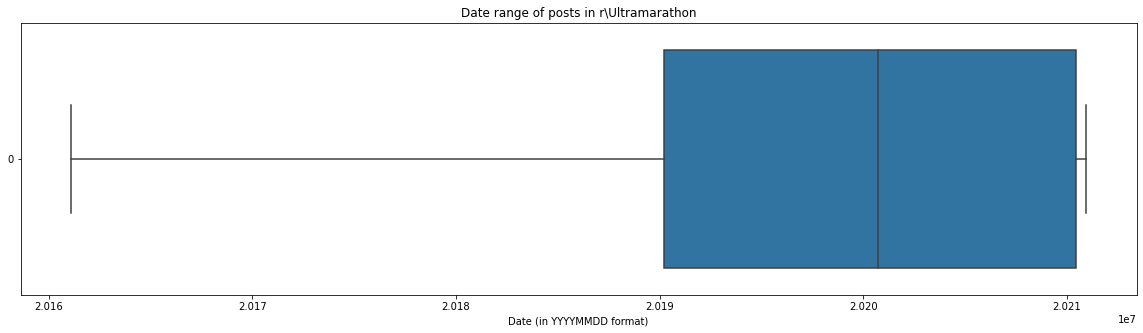

In [97]:
# Convert UTC time to yyyymmdd format, and plot date range
plt.figure(figsize = (20,5))

ax = sns.boxplot(
    data= [int(datetime.utcfromtimestamp(x).strftime("%Y%m%d")) for x in df1.created_utc],
    orient = "h",
)

ax.set_title(f"Date range of posts in r\\{subreddit1}")
ax.set_xlabel("Date (in YYYYMMDD format)");

While r\Ultramarathon has a 5 year date range for its posts, most of them are concentrated in the 2019-2021 range, so they are still quite recent. The 2019-2021 posts are also quite uniformly distributed around the median post. 

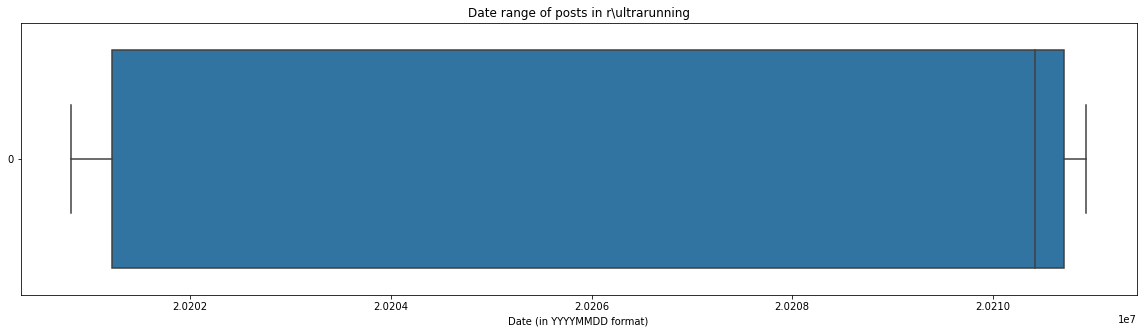

In [98]:
# Convert UTC time to yyyymmdd format, and plot date range
plt.figure(figsize = (20,5))

ax = sns.boxplot(
    data= [int(datetime.utcfromtimestamp(x).strftime("%Y%m%d")) for x in df2.created_utc],
    orient = "h",
)

ax.set_title(f"Date range of posts in r\\{subreddit2}")
ax.set_xlabel("Date (in YYYYMMDD format)");

No surprises here, as all of r\ultrarunning's posts are in 2020 and 2021. The only insight here is that this community is quite active recently, with the median post tilted to 2021.

r\ultrarunning clearly seems to be a more popular or active subreddit. However, less active does not mean worse, as the quality of posts may be more important. We shall move on to check on post length characteristics.

### Check low word count posts

In [99]:
df = pd.concat([df1, df2], axis = 0).reset_index(drop=True)
df['word_count'] = df['selftext'].map(lambda x: len(x.split()))

In [100]:
df.groupby('subreddit').agg({'word_count': ['min', 'median', 'mean', 'max']})

word_count                         
                     min median        mean   max
subreddit                                        
Ultramarathon          1   90.0  155.422000  3720
ultrarunning           1   93.0  139.470667  2663

The median post in r\Ultramarathon is slightly shorter than r\ultrarunning, but the mean word count is higher, so it suggests that some writers in the latter community write very long posts, perhaps ultracrockett!

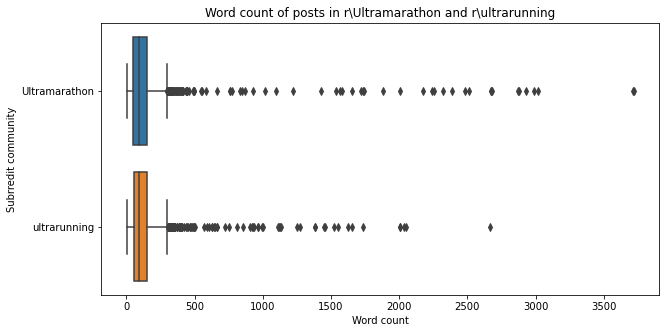

In [101]:
plt.figure(figsize = (10,5))
ax = sns.boxplot(data = df, 
                 x = "word_count", 
                 y = "subreddit",
                 orient = "h",
);

ax.set_title(f"Word count of posts in r\\{subreddit1} and r\\{subreddit2}")
ax.set_xlabel("Word count");
ax.set_ylabel("Subrredit community");

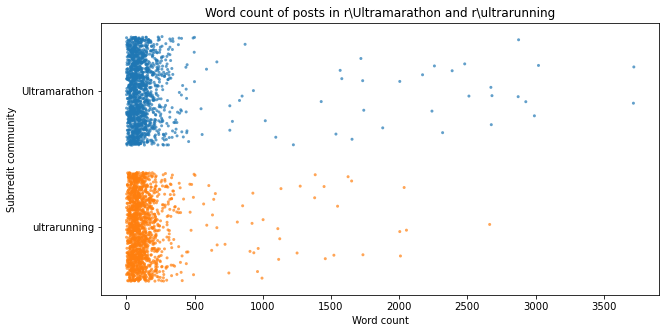

In [102]:
plt.figure(figsize = (10,5))
ax = sns.stripplot(data = df,
                   x = "word_count", 
                   y = "subreddit",
                   size = 3,
                   alpha = 0.7,
                   jitter = 0.4
                   
                
);

ax.set_title(f"Word count of posts in r\\{subreddit1} and r\\{subreddit2}")
ax.set_xlabel("Word count");
ax.set_ylabel("Subrredit community");

Box plots and strip plots suggest that writers in r\Ultramarathon write more than those in r\ultrarunning, with quite a number of them writing essay-length posts of over 2000 words!!
However, I do not see big material differences between the two communities of runners that will pose an obstacle to my problem statement.

In the groupby table above, I notice that the minimum number of words is 1. Let's analyse posts with low word counts to see if they are useful for my model. I start with a random sample of posts with 5 words or less.

In [103]:
# Count the number of posts with low word count
for i in range(1,6):
    print(f"There are {len(df[df['word_count'] == i])} posts of word count length = {i}.")

There are 15 posts of word count length = 1.
There are 4 posts of word count length = 2.
There are 3 posts of word count length = 3.
There are 5 posts of word count length = 4.
There are 10 posts of word count length = 5.


In [104]:
# Increase column width to view post contents
pd.set_option('display.max_colwidth', None)

In [105]:
# Sample posts with low word counts to see if they are useful
df.loc[df['word_count'] <= 5, :].sample(5)

,subreddit,author,title,selftext,created_utc,word_count
810,Ultramarathon,Ultramarathoner,2020 Barkley Marathons Cancelled,Jamil Coury announced it.,1584405073,4
1977,ultrarunning,mcdishy,"Sabrina Verjee breaks Wainrights Round record - 325 miles and 118,000 ft ascent in under 6 days!",https://www.weruntrails.co.uk/news/sabrina-verjee-sets-new-wainright-round-record,1623996912,1
2159,ultrarunning,MountainRunner911,Thoughts on ultrarunners using cannabis for recovery or just in general during training blocks?,Just curious about this.,1620440018,4
2438,ultrarunning,adriannairda,Is someone here doing the 4-4-48 challenge?,Any recommendations? Much appreciate it!,1613191090,5
1330,Ultramarathon,Dantoo2008,Peter Attila,How to achieve UM?,1520300400,4


It looks like vast majority of low word count posts are urls. Some are obvious spams, such as "love stream is at:..." These will be handled at the pre-processing stage.
Some are post of run timings, which may be relevant or useful information to readers and will be kept.

### Total word count
<a id='word_count_1'></a>

In [106]:
# Count starting number of words
print(f"Before pre-processing, I start with {df['word_count'].sum()} words in my dataset.")

Before pre-processing, I start with 442339 words in my dataset.


### Remove URLs

In [107]:
# Remove all text with "http" in it
df['cleaned_1'] = df['selftext'].map(
    lambda x: re.sub(r'http\S+', '', x)
)

In [108]:
# Sample to check rows with URLs orginally
df.loc[['http' in x for x in df['selftext']],['selftext','cleaned_1']].sample(2)

,selftext,cleaned_1
2380,Sorry it's in miles\n\n[View Poll](https://www.reddit.com/poll/lwjp9c),Sorry it's in miles\n\n[View Poll](
757,"Howdy ultra marathoners!\n\nIt still blows my mind that Pete Kostelnick averaged over 70 miles per day for 42 days to set his US trans-con record back in 2016 (and then followed it up with an unsupported 5000+ mile run from Alaska to Florida where he averaged over 50 miles per day for 98 days.\n\nSince we got so much positive feedback and great questions about our previous posts on race nutrition, I asked Pete to write [this piece about how he fuels for multi-day efforts](https://www.chaski.run/post/fueling-for-multiday-runs).\n\nHe's going to come into my account and answer some questions, so feel free to post them here!\n\nHappy running and more importantly, happy fueling!\n\nNote - Pete does NOT have a fuel/hydration sponsor; he is sponsored by Hoka and Squirrel's Nut butter (which is not food - it's lube)","Howdy ultra marathoners!\n\nIt still blows my mind that Pete Kostelnick averaged over 70 miles per day for 42 days to set his US trans-con record back in 2016 (and then followed it up with an unsupported 5000+ mile run from Alaska to Florida where he averaged over 50 miles per day for 98 days.\n\nSince we got so much positive feedback and great questions about our previous posts on race nutrition, I asked Pete to write [this piece about how he fuels for multi-day efforts](\n\nHe's going to come into my account and answer some questions, so feel free to post them here!\n\nHappy running and more importantly, happy fueling!\n\nNote - Pete does NOT have a fuel/hydration sponsor; he is sponsored by Hoka and Squirrel's Nut butter (which is not food - it's lube)"


In [109]:
# Refresh word count column
#   and check posts with low word count again
df['word_count'] = df['cleaned_1'].map(lambda x: len(x.split()))

for i in range(1,6):
    print(f"There are {len(df[df['word_count'] == i])} posts of word count length = {i}.")

There are 11 posts of word count length = 1.
There are 2 posts of word count length = 2.
There are 3 posts of word count length = 3.
There are 8 posts of word count length = 4.
There are 7 posts of word count length = 5.


### Check low word count posts again

There are just a handful of posts with 2 words or less. These might be the remnants of those posts that mainly most links to videos or other websites. Let's check them out.

In [110]:
# Sample posts with 2 word counts or less
df.loc[df['word_count'] <= 2, ['author','title','cleaned_1']]

,author,title,cleaned_1
219,mcdishy,Sabrina Verjee smashes Wainright round record!,
297,edgar_allen_snatch69,How many miles per week should you average in order to run a race that is 100+ miles?,\n\n[View Poll](
479,[deleted],Sleepiness,[deleted]
553,ExerciseThoughtStudy,We are a group of researchers at Rutgers University who are conducting a research study about thoughts and emotions during exercise. See the flyer for more information and to take our prescreen survey.,[\n\n
598,EubieDubieBlake,Desert Solstice is live on Youtube right now,
631,PooQuiche,"Hayden Hawks at the JFK50, bloody 'ell! Strava link below...",[
1203,clutchguy84,"Race report from Indiana Trail, 2018",[
1244,ThinkingTooHardAbouT,Ultrarunning in a nutshell: Two years ago during a 40M race I got stung eight times in the head by hornets and won. This year I got stung in the crotch. PB.,#beetoo
1294,tararunstheworld,Transylvania 50k Ultra was intense. I would recommend it for those that like pain.,[
1510,MuiMui888,Banning Vitamin I in UTMB. Seems a bit overreaching,


To delete all of the above posts, they are not written in proper English and won't contribute in training my model in predicting posts.

In [111]:
# Delete cleaned posts with 2 words or less
df = df.loc[df['word_count'] >2,:]
# Check
df.shape

(2981, 7)

In [112]:
# Check posts with 3 words
df.loc[df['word_count'] == 3, ['author','title','cleaned_1']]

,author,title,cleaned_1
506,King_falcon-113,Wyrr,Chose\n\n[View Poll](
673,cbskiddies,Does anyone know a 100 miler single loop or point to point going on west of Kansas in November or December?,Looking for recommendations!
686,SGF2YT,Ksjjs,Die die dieee


In [113]:
# Check posts with 4 words
df.loc[df['word_count'] == 4, ['subreddit','author','title','cleaned_1']]

,subreddit,author,title,cleaned_1
206,Ultramarathon,mcdishy,The UK’s Top 10 Ultramarathons,In one guys opinion! \n\n
505,Ultramarathon,King_falcon-113,Would you rather,Ok thx\n\n[View Poll](
810,Ultramarathon,Ultramarathoner,2020 Barkley Marathons Cancelled,Jamil Coury announced it.
893,Ultramarathon,bigtasty2019,What you pack (food/prep/first aid) for a 50K,Show me your goodies
1330,Ultramarathon,Dantoo2008,Peter Attila,How to achieve UM?
1443,Ultramarathon,Johnnytheknife,"For anyone interested, Comrades marathon starts in less than two hours...",Love stream is at:
1949,ultrarunning,mcdishy,The Top 10 UK Ultra’s,In one guys opinion! \n\n
2159,ultrarunning,MountainRunner911,Thoughts on ultrarunners using cannabis for recovery or just in general during training blocks?,Just curious about this.


In [114]:
# Check posts with 5 words
df.loc[df['word_count'] == 5, ['subreddit','author','title','cleaned_1']]

,subreddit,author,title,cleaned_1
556,Ultramarathon,MrDilkington1,"So how many 50's, 100k's and 75/80 mers did you do before running 100 miles?",Just trying to build perspective
761,Ultramarathon,optimisticpessimist5,What are some good 50 miles this year that have not been cancelled?,If there are any left.
974,Ultramarathon,05778,Why Not Kill This Subreddit?,And merge it with r/ultrarunning?
1077,Ultramarathon,Rogue_Artichoke,How do you all stretch daily?,Asking for a friend. :)
1305,Ultramarathon,ElHalcon,"My Aldi is featuring a Crane brand ultra-type hydration vest next week. Bladder not included, but...",[Hydration type vest at Aldi.](
2438,ultrarunning,adriannairda,Is someone here doing the 4-4-48 challenge?,Any recommendations? Much appreciate it!
2903,ultrarunning,exiveres,Racing?,Are any states allowing ultras?


After deleting posts with 2 or less words, I analyse posts with 3-5 words. 

It is clear that the longer the posts, the more relevant they are to running:
* Those with 3 words are irrelevant and will be killed off.
* Those with 4 words are less relevant so it should be okay killing it. For example, one has a message called "love stream is at:" while another author named mcdishy posted the same message on both subreddits giving his opinion of the top 10 ultramarathons in the UK.
* The posts with 5 words are somewhat relevant to running, so I shall keep them. Including one asking for r/Ultramarathon to be killed or merged with r/ultrarunning! Looks like I am not the only one feeling frustrated by two similar subreddit communities!!


In [115]:
# Remove posts with 3 and 4 words, retain only posts with 5 words and above

df = df.loc[df['word_count'] >= 5,:].reset_index(drop=True)
# Check
df.shape

(2970, 7)

A total of 30 mostly-irrelevant posts (== 1% of the original posts) are removed.

### Remove special characters

In [116]:
# Look at cleaned samples again
df[['subreddit','title','cleaned_1']].sample(5)

,subreddit,title,cleaned_1
943,Ultramarathon,North Texas Trails with Hills?,"Anyone from N Texas, DFW area and have found something reasonably close by for long runs? Jealous of all the awesome pics, thanks all!"
2085,ultrarunning,Training for first 50 mi. Is cycling acceptable training,Looking to see if anyone has had success subbing out one easy run for cycling. Starting to worry about durability and thought this would help. Thank you
214,Ultramarathon,Basic Training Tips,"Hello, I have been looking for a post on this but couldn't find one. I am new to ultramarathons but after my upcoming marathon this fall I would like to get into trail running and longer distances.\n\nMy question is sort of, how do you train for an ultra? Do you just go out and run, just longer distances? Does it depend on the race?\n\nI assume hills are more important to train on for ultras, should I be pushing up the hills or is walk/jog up hills enough? What type of nutrition changes are necessary, and what type of nutrition changes are recommended? \n\nI've found some of this online but there is a LOT of info out there to the point that I don't know what is the best advice. I hope some actual people can shed some light on the basics for me. Thank you!"
1961,ultrarunning,Questions on footwear for women ultra runners!,"Hi, I am a student working on a project specifically for women ultra runners. \n\nIn my research I've discovered that the increase in participation of women in ultra running/endurance actives has raised over 1600% in the past few years. Which is crazy! \n\nI wanted to design footwear for the girls ultra runners, and was hoping to get some insight on how current footwear could improve, or how footwear brands could do better reaching the female consumers in ultra events. \n\nAny insight, complaint, idea or thought would be amazing and really help me out."
2531,ultrarunning,Has anyone used Egg Weights?,"So I’m looking for ways to get more out of my runs without having to increase my mileage too much or add much time and saw the Egg Weights, sponsored by Zach Bitter. \n\nLink: \n\nHas anyone used egg weights and feels that they actually help their runs and the intensity of them as their website claims?"


Ran through a number of samples. Manually remove "\n", "\\" , "[]", "()", "|", "-", "&amp;#x200B". Because these subreddits are running-related, it is probably not a good idea to remove numbers as they are usually related to distances or timings. I will probably submitting numbers in my own posts to the subreddits too!

I also notice a lot of "ultras" and "ultramarathons" mentioned on both subreddits, so mental reminder to myself to include them as stop words.

In [117]:
# Replace specials characters
# df['cleaned_2'] = df['cleaned_1'].map(
#     lambda x: re.sub(r'[\n\\\[\]\(\)\|\-]', ' ', x)
# )

# Remove the %ampersand term
df['cleaned_2'] = df['cleaned_1'].map(
    lambda x: x.replace('&amp;#x200B;', ' ') 
)

# Extract words only    
df['cleaned_2'] = df['cleaned_2'].map(
    lambda x: re.sub('[^a-zA-Z]', ' ', x)
)


In [118]:
# Check for removal of special characters
df[['cleaned_1','cleaned_2']].sample(5)

,cleaned_1,cleaned_2
2815,"Hi all! I’ve got my first ultra (and first race lol) this weekend. It’s a 50 mi trail run. My goal is to finish in under 12 hours so I’ll be taking it pretty slow, trying to make sure I can actually finish. I’ve completed some longer training runs (marathon &amp; 50K) well under that pace so I’m feeling pretty confident about finishing.\n\nDo you have any advice for the week before, day before or morning of the race (start time 5am)? Also any race or post-race recovery tips would be appreciated!",Hi all I ve got my first ultra and first race lol this weekend It s a mi trail run My goal is to finish in under hours so I ll be taking it pretty slow trying to make sure I can actually finish I ve completed some longer training runs marathon amp K well under that pace so I m feeling pretty confident about finishing Do you have any advice for the week before day before or morning of the race start time am Also any race or post race recovery tips would be appreciated
1947,"Hi y'all! Looking to grab one or two more singlets for summer running as I have decided I really prefer them to shirts. My absolute favorite has been a craft nanoweight I picked up 2 years back. I have worn it for every race above 55 degrees along with an old style pair of Patagonia Striders (RIP good lining). It's tissue paper thin, super soft, and dries insanely fast, but it's been discontinued. I also love the fit (tighter) and style (racerback). What do you recommend in that vein? I have a basic brooks tank and don't love it as the fit is sloppy and it's a much rougher and thick fabric. Okay to pay a slight premium for something that will be durable and comfortable.",Hi y all Looking to grab one or two more singlets for summer running as I have decided I really prefer them to shirts My absolute favorite has been a craft nanoweight I picked up years back I have worn it for every race above degrees along with an old style pair of Patagonia Striders RIP good lining It s tissue paper thin super soft and dries insanely fast but it s been discontinued I also love the fit tighter and style racerback What do you recommend in that vein I have a basic brooks tank and don t love it as the fit is sloppy and it s a much rougher and thick fabric Okay to pay a slight premium for something that will be durable and comfortable
175,"By minimal support, I mean the way the race is designed. For example, events that have few aid stations, water-only stations, long distances between aid stations, no pacers or crew allowed, etc...\n\nAlso, I'm mostly talking about ultras the way they're done in North America - not Fell running, where only the most minimal of support is the norm. If you have done self-supported efforts, that's cool too, feel free to share, but I'm really curious about actual ultra race events.\n\nI'll start, the one that stands out to me is the Ute 100 near Moab in the La Sal Mountains. I ran the inaugural event and knew what I was getting into. There were long distances between some AS and some of those were water only, which meant carrying calories for about 30 miles at one point. The weather was super hot and there was not enough water on the course without filtering water. Also, at the finish there was no food, only water and beer. It was definitely a minimally supported event compared to almost every other race I've run.",By minimal support I mean the way the race is designed For example events that have few aid stations water only stations long distances between aid stations no pacers or crew allowed etc Also I m mostly talking about ultras the way they re done in North America not Fell running where only the most minimal of support is the norm If you have done self supported efforts that s cool too feel free to share but I m really curious about actual ultra race events I ll start the one that stands out to me is the Ute near Moab in the La Sal Mountains I ran the inaugural event and knew what I was getting into There were long distanc

A few rounds of sampling shows that the cleaning looks fine.

### Check sentiment

I am curious to find out the general sentiment of writers in these two subreddits, want to see if there is a discernible difference between each community. I use the VADER (Valence Aware Dictionary and sEntiment Reasoner) lexicon to analyze the sentiments of our posts.

In [119]:
# Create sentiment column
sent = SentimentIntensityAnalyzer()
df['sentiment'] = df['cleaned_2'].map(lambda x: sent.polarity_scores(x)['compound'])

In [120]:
# Check sentiment
df.groupby('subreddit').agg({'sentiment': ['min', 'median', 'mean', 'max']})

sentiment                           
                    min   median      mean     max
subreddit                                         
Ultramarathon   -0.9979  0.69045  0.495699  0.9999
ultrarunning    -0.9969  0.69080  0.460700  0.9997

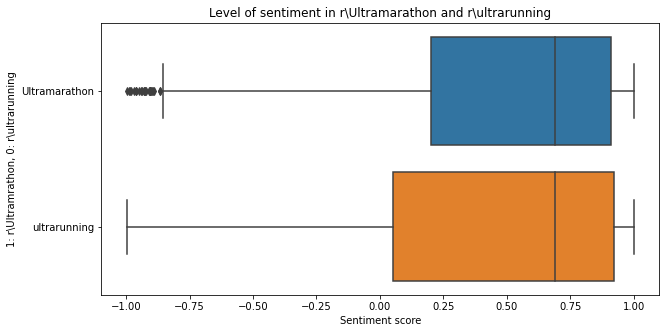

In [121]:
plt.figure(figsize = (10,5))
ax = sns.boxplot(data = df, 
                 x = "sentiment", 
                 y = "subreddit",
                 orient = "h",
);

ax.set_title(f"Level of sentiment in r\\{subreddit1} and r\\{subreddit2}")
ax.set_xlabel("Sentiment score");
ax.set_ylabel("1: r\\Ultramrathon, 0: r\\ultrarunning");

The median runner-author seems to be a very positive person, with a score of 0.69 for both subreddits. The mean score is much lower for both communities, dragged down by a number of neutral and negative posts. I cannot discern a material difference between posts in the two subreddit communities based on VADER sentiment analysis.

### Tokenize words

I shall make all words lower case and split by blank spaces.

In [122]:
# Tokenizing...
df['cleaned_3'] = df['cleaned_2'].map(lambda x: x.lower().split())
# Check
df[['cleaned_1','cleaned_2','cleaned_3']].sample(5)

,cleaned_1,cleaned_2,cleaned_3
2915,"Here's how my daily run goes 6 months of the year: Dew covered plants --&gt; stream flowing down the mud ""trail"" --&gt; deep snow --&gt; packed snow. My Nike Pegasus Trail are SOAKED the whole time, every time\n\nI was told ""having wet feet is just part of it"" but cmon... this is like SLOSH SLOSH SLOSH for an hour every morning, not ""get wet and run til you're dry""\n\nI tried on some Dynafit Sky Pro fully waterproof and my feet were sweaty and steamy after about 10 minutes in the house, so I get the hate of waterPROOF shoes, but surely there's a middle ground between the Nike Sponges and Dynafit Drybags\n\nLooking at Lone Peak RSM?",Here s how my daily run goes months of the year Dew covered plants gt stream flowing down the mud trail gt deep snow gt packed snow My Nike Pegasus Trail are SOAKED the whole time every time I was told having wet feet is just part of it but cmon this is like SLOSH SLOSH SLOSH for an hour every morning not get wet and run til you re dry I tried on some Dynafit Sky Pro fully waterproof and my feet were sweaty and steamy after about minutes in the house so I get the hate of waterPROOF shoes but surely there s a middle ground between the Nike Sponges and Dynafit Drybags Looking at Lone Peak RSM,"[here, s, how, my, daily, run, goes, months, of, the, year, dew, covered, plants, gt, stream, flowing, down, the, mud, trail, gt, deep, snow, gt, packed, snow, my, nike, pegasus, trail, are, soaked, the, whole, time, every, time, i, was, told, having, wet, feet, is, just, part, of, it, but, cmon, this, is, like, slosh, slosh, slosh, for, an, hour, every, morning, not, get, wet, and, run, til, you, re, dry, i, tried, on, some, dynafit, sky, pro, fully, waterproof, and, my, feet, were, sweaty, and, steamy, after, about, minutes, in, the, house, so, i, get, the, hate, of, waterproof, ...]"
348,"I recently took a new job (I'm employed!), but the combination of the hours (8AM-5PM plus a 30 min. commute) and where I live in relation to my time zone means I have super late sunrises and sunsets. This is means that other than peak summer, I will be doing 5 days a week of running in the dark, and 2 of running in light (the weekends). I was just hoping to hear of how other people deal with this (looking for more mental side of things, I will be getting all the lights I need), and whether you get used to it. Anything unexpected I should be aware of? Thanks!",I recently took a new job I m employed but the combination of the hours AM PM plus a min commute and where I live in relation to my time zone means I have super late sunrises and sunsets This is means that other than peak summer I will be doing days a week of running in the dark and of running in light the weekends I was just hoping to hear of how other people deal with this looking for more mental side of things I will be getting all the lights I need and whether you get used to it Anything unexpected I should be aware of Thanks,"[i, recently, took, a, new, job, i, m, employed, but, the, combination, of, the, hours, am, pm, plus, a, min, commute, and, where, i, live, in, relation, to, my, time, zone, means, i, have, super, late, sunrises, and, sunsets, this, is, means, that, other, than, peak, summer, i, will, be, doing, days, a, week, of, running, in, the, dark, and, of, running, in, light, the, weekends, i, was, just, hoping, to, hear, of, how, other, people, deal, with, this, looking, for, more, mental, side, of, things, i, will, be, getting, all, the, lights, i, need, and, whether, you, get, used, ...]"
1443,"Hey all, I'm doing the Zion 55K next weekend and have a couple questions about the area for anyone who has done the race or even just run in that area.\n\nFirst, what is the terrain like? I'm used to running in the Southwest on rocky / gravely trails in a pair of Newton trail shoes. I also have a pair of Altra's with a lot more cushioning that I'm planning on bringing just in case. Are there any suggestions on which 

In [123]:
# Count total number of words again
np.sum([len(x) for x in df['cleaned_3']])

441016

After cleaning and splitting, I actually end up with more words in total (444,833) than my [initial naive word count](#word_count_1) of 442,751.

### Common words analysis
<a id='common_words'></a>

I shall first look at word frequency and conduct a few iterations of different "stop words".

In [124]:
# Create function to analyse top 20 most frequently used words 
#   with defined stop-words dictionary 
def frequentwords(data, column_name = None, stopwords = None, n = 1):
    cvec = CountVectorizer(
        stop_words = stopwords,   # Default is no stop words
        ngram_range = (n,n)      # Default is to analyze 1-gram only
    )
    
    # Create word vector on subreddit1 
    vector1 = cvec.fit_transform(
        data.loc[
            data['subreddit'] == subreddit1,
            column_name
        ]
    )
    vector1_df = pd.DataFrame(
        vector1.todense(),
        columns = cvec.get_feature_names()
    ).sum(
    ).sort_values(
        ascending = False
    )
#     print(vector1_df)
    
    # Create word vector on subreddit2
    vector2 = cvec.fit_transform(
        data.loc[
            data['subreddit'] == subreddit2,
            column_name
        ]
    )
    vector2_df = pd.DataFrame(
        vector2.todense(),
        columns = cvec.get_feature_names()
    ).sum(
    ).sort_values(
        ascending = False
    )
#     print(vector2_df)
    
    # Prepare subplot area
    fig, axes = plt.subplots(figsize = (10,15), nrows = 3, ncols = 1)
    
    # Plot top 20 most common words
    ax1 = sns.barplot(
        x = vector1_df.head(20).values,
        y = vector1_df.head(20).index,
        orient = 'h',
        ax = axes[0]
    )
    ax1.set_title(f"Top 20 most common words for r\\{subreddit1}")
    ax1.set_xlabel("Frequency")
    ax1.set_ylabel("Words");
    
    ax2 = sns.barplot(
        x = vector2_df.head(20).values,
        y = vector2_df.head(20).index,
        orient = 'h',
        ax = axes[1]
    )
    ax2.set_title(f"Top 20 most common words for r\\{subreddit2}")
    ax2.set_xlabel("Frequency")
    ax2.set_ylabel("Words");
    
    # Plot Venn diagram to check intersection of 50 most common words
    ax3 = venn2(
        [
            set(vector1_df.head(50).index),
            set(vector2_df.head(50).index)
        ],
        set_labels = (f'r\\{subreddit1}', f'r\\{subreddit2}')
    )
    plt.title('Top 50 words in posts')
    plt.tight_layout()

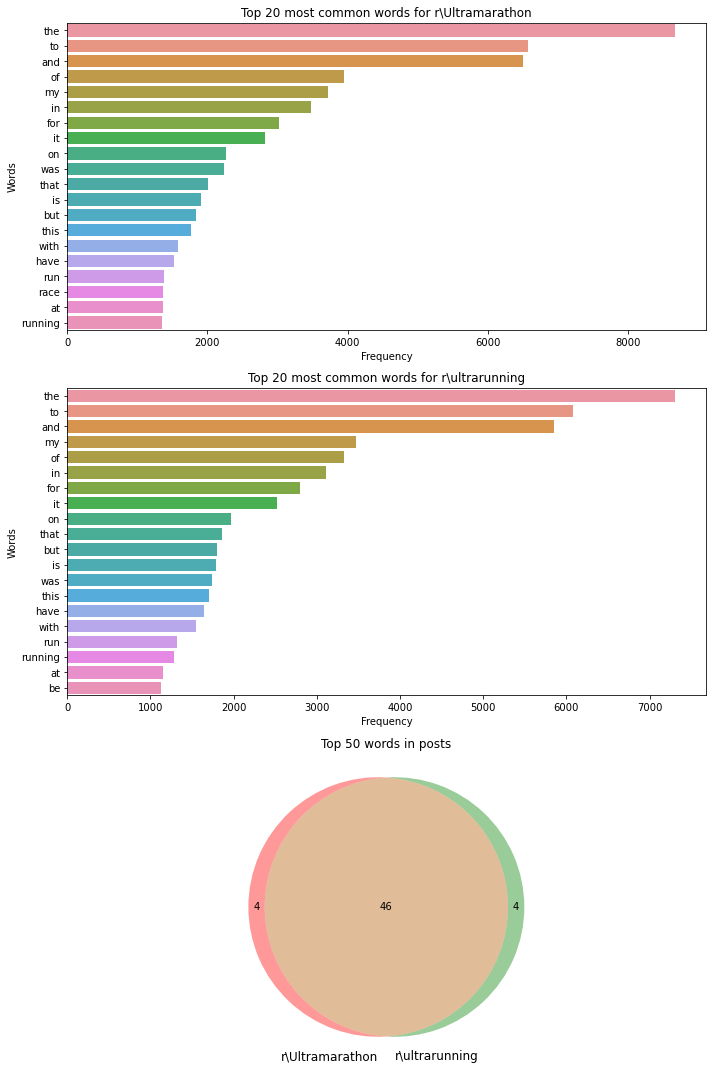

In [125]:
# Check most frequent words for subreddits
frequentwords(df, 'cleaned_2')

Both subreddits have almost exactly the same common words! That doesn't bode well for differentiating between subreddits. I shall apply NLTK's default stop word dictionary and see if anything changes.

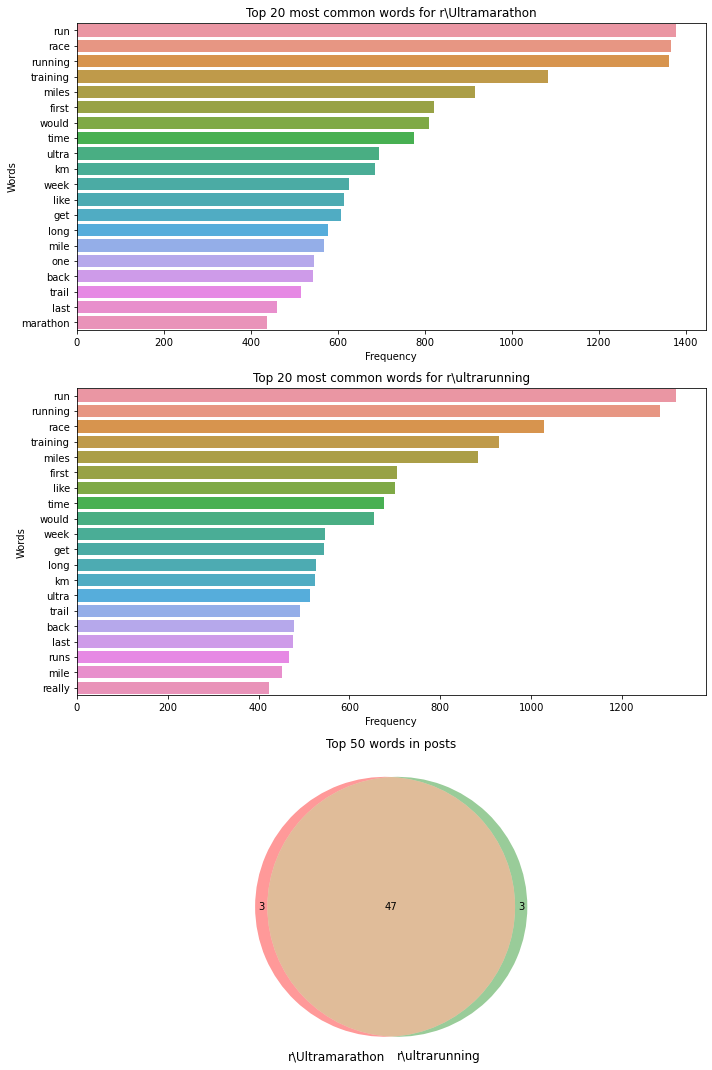

In [126]:
# Apply nltk stop words
words_to_remove = stopwords.words('english')

# Check most frequent words after stop word removal
frequentwords(df, 'cleaned_2', words_to_remove)

Looking better now. Here are some additional words to remove in the next round:
- Remove "ultramarathon", "ultramarathons", "ultrarunning" from both subreddits, to avoid giving the model an unfair advantage since the purpose is to figure out if a post should belong to r\Ultramarathon or r\ultrarunning
- Remove common running words such as "run", "running", "race", "training", "miles", "mile"

In [127]:
# Round 3: Expand stop word dictionary
words_to_remove += ["ultramarathon", "ultramarathons", "ultrarunning"]
words_to_remove += ["run", "running", "race", "training", "miles", "mile"]

In [128]:
# Check last few words in dict
words_to_remove[-20:]

["shan't",
 'shouldn',
 "shouldn't",
 'wasn',
 "wasn't",
 'weren',
 "weren't",
 'won',
 "won't",
 'wouldn',
 "wouldn't",
 'ultramarathon',
 'ultramarathons',
 'ultrarunning',
 'run',
 'running',
 'race',
 'training',
 'miles',
 'mile']

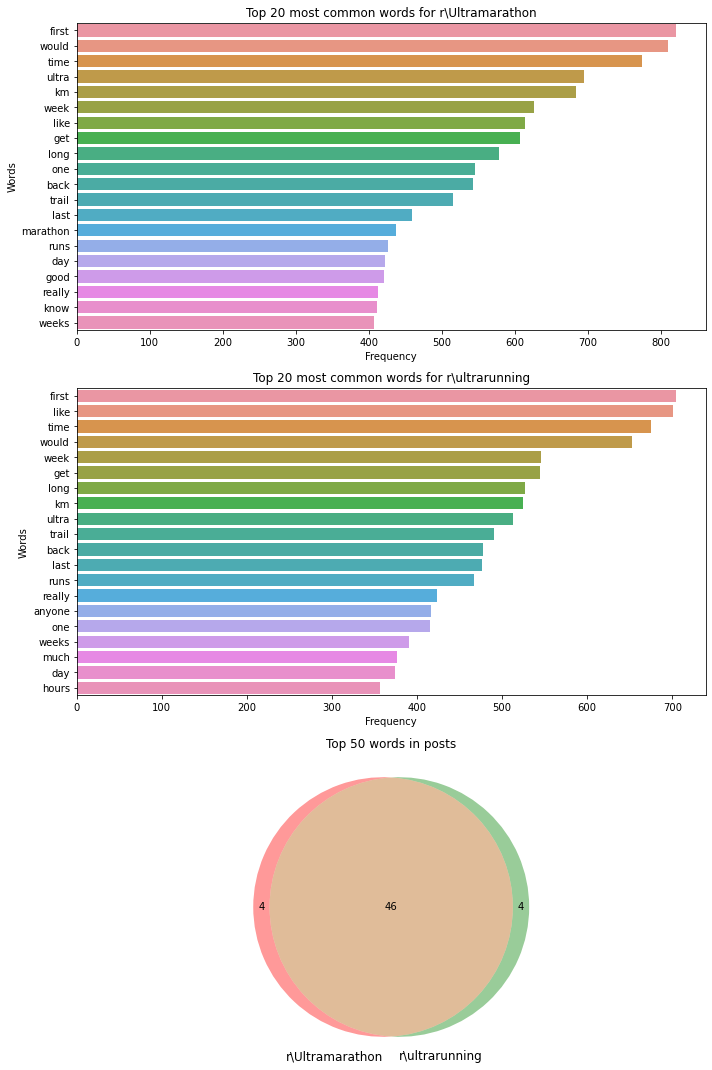

In [129]:
# Check most frequent words after additional stop words 
frequentwords(df, 'cleaned_2', words_to_remove)

The most frequently used words are starting to look a little more different between the two subreddits but still a lot of similarities. It seems like it will be an uphill task for my classification model later. 

However, we cannot just remove all intersected words as they may be constituents of meaningful bigrams or trigrams. Let's take a look at them now.


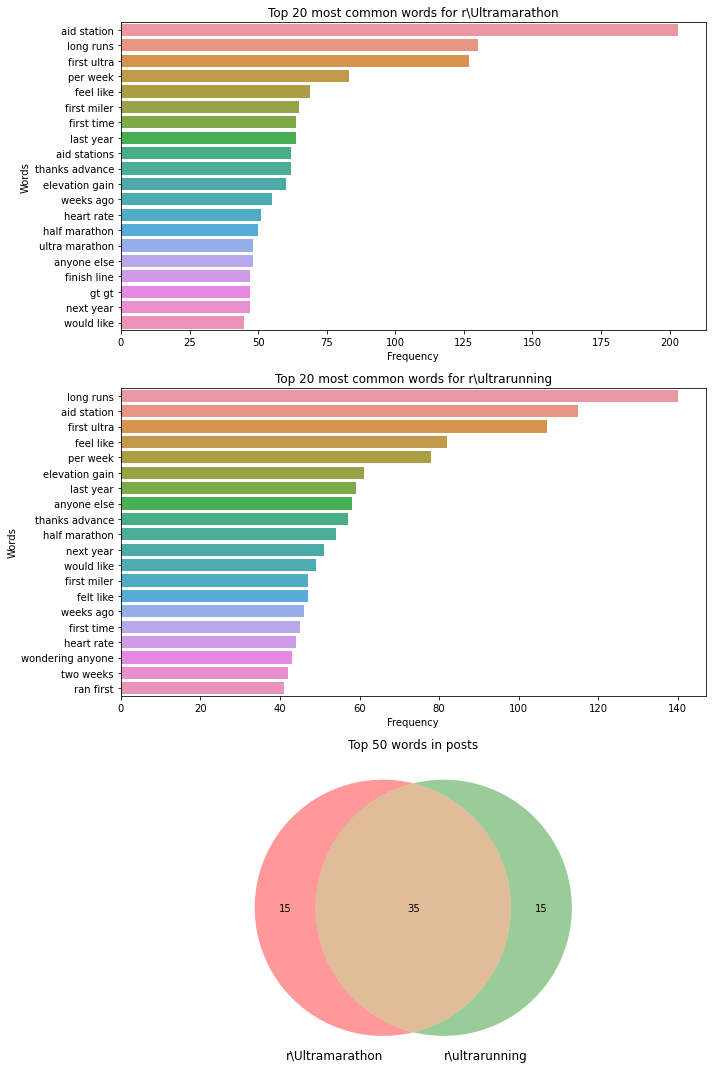

In [130]:
# Analyze bi-grams in subreddits
frequentwords(df, 'cleaned_2', words_to_remove, 2)

Bi-grams for both subreddits are also quite similar. Classificatio model won't be easy to train well...

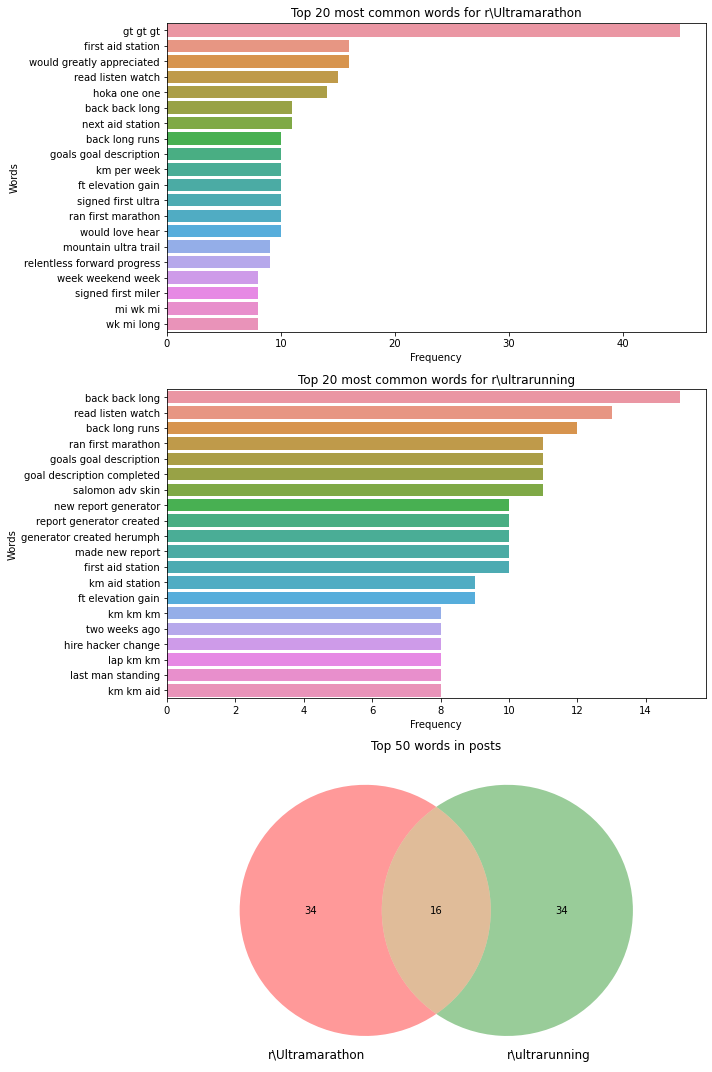

In [131]:
# Analyze tri-grams in subredditsa
frequentwords(df, 'cleaned_2', words_to_remove, 3)

I can see more differentiation in tri-grams coming from the two subreddit communities. That gives a bit of hope for the modeling, as I can run word vectorizers that utilizes bigrams and trigrams.

### Lemmatize and stemmatize

Next step is to lemmatize the word tokens.

In [132]:
# Lemmatize after removing stop words
lemmatizer = WordNetLemmatizer()

df['cleaned_lemma'] = df['cleaned_3'].map(
    lambda x: [lemmatizer.lemmatize(token) \
               for token in x \
               if token not in words_to_remove]
).map(
    lambda x: ' '.join(x)
)

In [133]:
# Check
df[['cleaned_2', 'cleaned_lemma']].sample(5)

,cleaned_2,cleaned_lemma
466,Hi everybody I am very new to the whole ultrarunning community and such The most I have ever ran is miles but on March th I will be participating in David Goggin s x x I m not sure if this is allowed or not here but I am posting my fundraiser It is to raise money for those in need of food and to help against world hunger Stop Hunger x x I have a goal to be raised and would greatly appreciate any sharing Thank you and stay hard,hi everybody new whole community ever ran march th participating david goggin x x sure allowed posting fundraiser raise money need food help world hunger stop hunger x x goal raised would greatly appreciate sharing thank stay hard
1129,Hello fellow ultrarunning lunatics Just finished my first k at Bandera this past Saturday and had some serious issues during the back half with blisters developing on both my heels that made for an extremely unpleasant time picture I ve never had this happen during any runs before and I think it may be related to me having to power hike the vast majority of the second loop after overheating in the midday sun Any pointers on how to about this going forward I was running in Altra Timp s wearing Ininji midweight run socks and applied Body Glide Foot to both feet before the race though I did not reapply when changing socks at the midway point Also anybody have any tips for treating these ugly mofos Still rather painful to walk even in flip flops Thanks in advance,hello fellow lunatic finished first k bandera past saturday serious issue back half blister developing heel made extremely unpleasant time picture never happen run think may related power hike vast majority second loop overheating midday sun pointer going forward altra timp wearing ininji midweight sock applied body glide foot foot though reapply changing sock midway point also anybody tip treating ugly mofos still rather painful walk even flip flop thanks advance
160,My mom specifically is super freaked out by the idea of me running a miler Works in a hospital and has a seen a lot of nasty stuff and since she s not into running I think miles sounds ludicrously dangerous Worried about me twisting something breaking something or just dying somehow during the run which I ll be as prepared for as I can be I ve run two k s and two milers and I m setting my sights on a a little over a year from now I really want her on board Have any of y all dealt with this with parents family partners or friends If so have you found anything to share that helps Also while I appreciate that she just has to understand it s your life is a valid perspective I know that already and am looking for supplemental material,mom specifically super freaked idea miler work hospital seen lot nasty stuff since think sound ludicrously dangerous worried twisting something breaking something dying somehow prepared two k two miler setting sight little year really want board dealt parent family partner friend found anything share help also appreciate understand life valid perspective know already looking supplemental material
397,I asked for advice a few weeks ago on whether or not running a mile time trial a couple months out from a miler would be a good idea I decided to go for a miler and was super happy with the results I think I got everything out of it that I wanted to my fueling strategy worked great my feet held up just fine I ran it barefoot and my pace was super even I d intended on going out at mile pace but just felt jumpy and itching to go faster so I gradually dropped the pace down and then settled into a nice steady pace Anyways I appreciated the advice and support on the sub Thanks You can find the GPS here and a full write up of the run here,asked advice week ago whether time trial couple month miler would good idea decided go miler super happy result think got everything wanted fueling strategy worked great foot held fine ran barefoot pace super even intended going pace felt jumpy itching go faster gradually dro

Next, I apply [Porter's stemmer](https://www.cs.toronto.edu/~frank/csc2501/Readings/R2_Porter/Porter-1980.pdf) to return the base form of words. It tends to be cruder than using lemmatization only, so I shall check out both methods to see which works better.

In [134]:
# Stemmatize after removing stop words
stemmer = PorterStemmer()

df['cleaned_stemmer'] = df['cleaned_3'].map(
    lambda x: [stemmer.stem(token) \
               for token in x \
               if token not in words_to_remove]
).map(
    lambda x: ' '.join(x)
)

In [135]:
# Check
df[['cleaned_3', 'cleaned_lemma', 'cleaned_stemmer']].sample(5)

,cleaned_3,cleaned_lemma,cleaned_stemmer
581,"[when, i, need, a, running, jacket, i, reach, for, my, year, under, armour, running, jacket, it, s, completely, unbreathable, and, while, it, use, to, be, rain, resistant, that, was, a, long, time, ago, anything, beyond, a, dizzle, soaks, it, basically, it, sucks, i, decided, it, s, time, to, stop, being, so, cheap, and, invest, in, a, new, jacket, i, m, looking, for, suggestions, for, a, new, running, jacket, what, do, y, all, wear]",need jacket reach year armour jacket completely unbreathable use rain resistant long time ago anything beyond dizzle soak basically suck decided time stop cheap invest new jacket looking suggestion new jacket wear,need jacket reach year armour jacket complet unbreath use rain resist long time ago anyth beyond dizzl soak basic suck decid time stop cheap invest new jacket look suggest new jacket wear
1244,"[hi, folks, i, have, been, rocking, a, garmin, forerunner, for, the, last, years, and, love, it, although, feel, i, should, invest, in, something, a, bit, more, modern, and, sleek, for, the, next, years, the, garmin, xt, caught, my, eye, as, i, have, recently, started, an, hr, or, two, a, week, of, open, water, sea, swimming, and, would, like, to, increase, my, non, existent, pool, swimming, and, maybe, a, xt, will, spark, a, bit, of, interest, in, pool, swimming, as, the, did, for, running, would, a, xt, be, a, good, worthy, upgrade, and, should, i, bother, with, the, hr, strap, and, ...]",hi folk rocking garmin forerunner last year love although feel invest something bit modern sleek next year garmin xt caught eye recently started hr two week open water sea swimming would like increase non existent pool swimming maybe xt spark bit interest pool swimming would xt good worthy upgrade bother hr strap finally use garmin footpod redundant xt still needed around time week usually take part marathon throughout year ultras thanks,hi folk rock garmin forerunn last year love although feel invest someth bit modern sleek next year garmin xt caught eye recent start hr two week open water sea swim would like increas non exist pool swim mayb xt spark bit interest pool swim would xt good worthi upgrad bother hr strap final use garmin footpod redund xt still need around time week usual take part marathon throughout year ultra thank
2355,"[i, m, training, for, my, first, k, as, a, fairly, slow, runner, minute, miles, easy, pace, but, i, walk, all, the, uphills, on, my, hilly, long, runs, so, i, end, up, averaging, minute, miles, my, long, runs, are, starting, to, hit, around, hours, and, i, am, looking, for, ideas, for, hydration, i, have, shoulder, issues, had, a, labral, tear, several, years, ago, and, it, hurts, a, lot, to, wear, running, vests, due, to, the, lack, of, frame, i, can, hike, with, a, frame, backpack, with, hip, belt, but, is, very, uncomfortable, to, run, in, today, i, am, using, the, ultraspire, ...]",first k fairly slow runner minute easy pace walk uphill hilly long run end averaging minute long run starting hit around hour looking idea hydration shoulder issue labral tear several year ago hurt lot wear vest due lack frame hike frame backpack hip belt uncomfortable today using ultraspire speedgoat waist belt really like plan use plenty aid station hold l water barely sufficient hour continue ramp hoping peak looking non vest option hold l water anyone luck adding additional bottle waist belt considered also carrying handheld could never use pole suspect would feel awkward tried also considered getting smallest hiking pack find still frame hipbelt like osprey talon worried may chafe water slosh around lot interested see strategy others used worst case two smaller route refill car local route water trail purify much interested staying whole time,first k fairli slow runner minut easi pace walk uphil hilli long run end averag minut long run start hit around hour look idea hydrat shoulder issu labral tear sever year ago hurt lot wear vest due lack fram

Stemmer looks terrible...but hey, it might work better! Let's see in the next section.

### Total word count again

In [136]:
# Count total number of words in lemmatized posts and stemmatized posts
print(f"The original total word count is {df['word_count'].sum()}.")
print(f"Total word count after lemmatization is {np.sum([len(x.split()) for x in df['cleaned_lemma']])}.")
print(f"Total word count after stemmatization is {np.sum([len(x.split()) for x in df['cleaned_stemmer']])}.")

The original total word count is 442079.
Total word count after lemmatization is 203735.
Total word count after stemmatization is 203735.


In [137]:
df.shape

(2970, 12)

In [138]:
234327 / 442257 -1

-0.47015649271803495

To summarize, after data pre-processing, a total of 30 rows (1% of original) are removed, and about 47% of the words in posts are remove.

### Remove other special characters??

## Modeling

### Binarize subreddit column

I set r\Ultramarathon as "1" and r\ultrarunning as "0".

In [139]:
# Binarize
df['target'] = df['subreddit'].map({'Ultramarathon' : 1,
                                       'ultrarunning' : 0})


# Reset column width 
pd.set_option('display.max_colwidth', 50)

# Check
df

,subreddit,author,title,selftext,created_utc,word_count,cleaned_1,cleaned_2,sentiment,cleaned_3,cleaned_lemma,cleaned_stemmer,target
0,Ultramarathon,tizawer,MCM 50k Sale,Purchased registration for the Marine Corps Ma...,1632537589,22,Purchased registration for the Marine Corps Ma...,Purchased registration for the Marine Corps Ma...,0.0000,"[purchased, registration, for, the, marine, co...",purchased registration marine corp marathon k ...,purchas registr marin corp marathon k sold loo...,1
1,Ultramarathon,lazysl0b,What’s your baseline MPW and schedule?,I’ve done a couple of ultras now and want to b...,1632472993,83,I’ve done a couple of ultras now and want to b...,I ve done a couple of ultras now and want to b...,0.6059,"[i, ve, done, a, couple, of, ultras, now, and,...",done couple ultras want build slowly miler hop...,done coupl ultra want build slowli miler hope ...,1
2,Ultramarathon,ultracrockett,Spartathlon,Spartathlon (246 km/153 miles) starts tomorrow...,1632428494,105,Spartathlon (246 km/153 miles) starts tomorrow...,Spartathlon km miles starts tomorrow...,-0.2500,"[spartathlon, km, miles, starts, tomorrow, for...",spartathlon km start tomorrow th year greece a...,spartathlon km start tomorrow th year greec an...,1
3,Ultramarathon,laflame1738,Advice before my first ultra,I am a D3 runner who is finishing up there las...,1632405780,113,I am a D3 runner who is finishing up there las...,I am a D runner who is finishing up there las...,0.2144,"[i, am, a, d, runner, who, is, finishing, up, ...",runner finishing last cross country season loo...,runner finish last cross countri season look a...,1
4,Ultramarathon,ghostbrainalpha,Who is in better shape for a 100 mile race?,Neither person is remotely close to being capa...,1632332323,28,Neither person is remotely close to being capa...,Neither person is remotely close to being capa...,0.2023,"[neither, person, is, remotely, close, to, bei...",neither person remotely close capable ultra pe...,neither person remot close capabl ultra person...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2965,ultrarunning,Redhawkgirl,Does anyone else struggle with carb intake?,I know the science and I need to eat more carb...,1597639225,199,I know the science and I need to eat more carb...,I know the science and I need to eat more carb...,-0.2010,"[i, know, the, science, and, i, need, to, eat,...",know science need eat carbohydrate interested ...,know scienc need eat carbohydr interest keto f...,0
2966,ultrarunning,veggie-burrito,Should minutes per mile/km increase/decrease a...,"Hey friends! So, I'm slowly upping my mileage,...",1597618387,116,"Hey friends! So, I'm slowly upping my mileage,...",Hey friends So I m slowly upping my mileage ...,0.9650,"[hey, friends, so, i, m, slowly, upping, my, m...",hey friend slowly upping mileage new world ult...,hey friend slowli up mileag new world ultra to...,0
2967,ultrarunning,Scrubfire,I did my first 100k yesterday,"All my races were cancelled this year, includi...",1597594443,396,"All my races were cancelled this year, includi...",All my races were cancelled this year includi...,0.9496,"[all, my, races, were, cancelled, this, year, ...",race cancelled year including first k k cape n...,race cancel year includ first k k cape nova sc...,0
2968,ultrarunning,local_boy,Dan Lawson - New LEJOG FKT,In the early hours of this morning Dan Lawson ...,1597573708,41,In the early hours of this morning Dan Lawson ...,In the early hours of this morning Dan Lawson ...,0.0000,"[in, the, early, hours, of, this, morning, dan...",early hour morning dan lawson set new authenti...,earli hour morn dan lawson set new authent fkt...,0


### Baseline score

In [140]:
# Check baseline score
df.target.value_counts(normalize = True)

0    0.50101
1    0.49899
Name: target, dtype: float64

The baseline score to beat is 50.1%

### Check data again

In [141]:
# Check nulls
df.isnull().sum()

subreddit          0
author             0
title              0
selftext           0
created_utc        0
word_count         0
cleaned_1          0
cleaned_2          0
sentiment          0
cleaned_3          0
cleaned_lemma      0
cleaned_stemmer    0
target             0
dtype: int64

### Create train test sets

In [142]:
# Create train test sets
X = df['cleaned_lemma']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify = y,
    random_state = 42
)

In [143]:
# Check
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2227,), (743,), (2227,), (743,))

### Create custom function

I create a custom function that automates a few steps:
* Instantiate a GridSearchCV
* Fit on train set
* Create confusion matrix on test set
* Print results of best parameters, best score, train score, test score and various confusion matrix metrics

In [144]:
# Create function to run pipe and print results
def run_grid(X_train, X_test, y_train, y_test):
    # Instantiate GridSearchCV
    gs = GridSearchCV(
        pipe, 
        param_grid = params, 
        n_jobs= -1, 
        cv=5)

    # Fit model
    gs.fit(X_train, y_train)

    # Confusion matrix
    y_pred = gs.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Print results
    print(f'Mean CV score: {gs.best_score_:.3f}')
    print('Best Parameters:', gs.best_params_)
    print(f'Train score: {gs.score(X_train, y_train):.3f}')
    print(f'Test score (aka Accuracy): {gs.score(X_test, y_test):.3f}')
    print(f'Sensitivity: {tp/(tp+fn):.3f}, Specificity: {tn/(tn+fp):.3f}, Precision: {tp/(tp+fp):.3f}')

### Parametric models

#### CountVectorizer / Multinomial

In [145]:
%%time
# Make pipe
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

# Set parameters
params = {
    'cvec__min_df': [1, 2],
    'cvec__max_df': [.1, .25, .5, 1],
    'cvec__max_features' : [500, 1000, 2000],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'nb__alpha': [.25, .5, 1]
}

# Run pipe in GridSearchCV and print results
run_grid(X_train, X_test, y_train, y_test)

Mean CV score: 0.551
Best Parameters: {'cvec__max_df': 0.25, 'cvec__max_features': 500, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'nb__alpha': 1}
Train score: 0.651
Test score (aka Accuracy): 0.536
Sensitivity: 0.512, Specificity: 0.559, Precision: 0.537
CPU times: user 4.59 s, sys: 930 ms, total: 5.52 s
Wall time: 1min 17s


The train score (0.65) is much higher than test score (0.54), so this is a sign of overfitting. The test score isn't too far away from the train set's cross_val_score (0.55) so this model is quite disappointing.

As there are too many common words across all posts and between subreddits, I shall try Term Frequency-Inverse Document Frequency (TF-IDF) Vectorizer next. This method will give more weight to words that occur often in one post but don't occur in many posts, hopefully this can create more predictive power in my model.

#### TfidfVectorizer / Multinomial

In [146]:
%%time
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# Set parameters
params = {
    'tvec__min_df': [1, 2],
    'tvec__max_df': [.1, .25, .5, 1],
    'tvec__max_features' : [500, 1000, 2000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'nb__alpha': [.25, .5, 1]
}

# Run pipe in GridSearchCV and print results
run_grid(X_train, X_test, y_train, y_test)

Mean CV score: 0.552
Best Parameters: {'nb__alpha': 0.5, 'tvec__max_df': 0.5, 'tvec__max_features': 500, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1)}
Train score: 0.682
Test score (aka Accuracy): 0.541
Sensitivity: 0.526, Specificity: 0.556, Precision: 0.542
CPU times: user 4.66 s, sys: 806 ms, total: 5.47 s
Wall time: 1min 24s


TF-IDF seems to work a bit better. Both the mean cross-validated score and test score are marginally higher... 
Will try logit model next.

#### CountVectorizer / Logistic

In [147]:
%%time
# Make pipe
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('logit', LogisticRegression())
])

# Set parameters
params = {
    'cvec__min_df': [1, 2],
    'cvec__max_df': [.1, .25, .5, 1],
    'cvec__max_features' : [500, 1000, 2000],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'logit__C': [0.1, 1, 10],
    'logit__max_iter': [1_000]
}

# Run pipe in GridSearchCV and print results
run_grid(X_train, X_test, y_train, y_test)

Mean CV score: 0.545
Best Parameters: {'cvec__max_df': 0.5, 'cvec__max_features': 500, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'logit__C': 10, 'logit__max_iter': 1000}
Train score: 0.727
Test score (aka Accuracy): 0.522
Sensitivity: 0.536, Specificity: 0.508, Precision: 0.521
CPU times: user 4.94 s, sys: 834 ms, total: 5.77 s
Wall time: 1min 40s


Logistic model is worse. It suffers from a more severe case of overfitting as its train score is much higher than multinomial (0.727 vs 0.651) but its cv score on train set and accuracy score on test set are lower than multinomial's (0.545 vs 0.551 and 0.522 vs 0.536). 

I am not optimistic that using TF-IDF Vectorizer as word vectorizer will generate better results than Count Vectorizer, since it didn't work so well for MultinomialNB, but let's give it a try..

#### TfidfVectorizer / Logistic

In [148]:
%%time
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logit', LogisticRegression())
])

# Set parameters
params = {
    'tvec__min_df': [1, 2],
    'tvec__max_df': [.1, .25, .5, 1],
    'tvec__max_features' : [500, 1000, 2000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'logit__C': [0.1, 1, 10],
    'logit__max_iter': [1_000]
}

# Run pipe in GridSearchCV and print results
run_grid(X_train, X_test, y_train, y_test)

Mean CV score: 0.558
Best Parameters: {'logit__C': 0.1, 'logit__max_iter': 1000, 'tvec__max_df': 0.25, 'tvec__max_features': 500, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1)}
Train score: 0.668
Test score (aka Accuracy): 0.534
Sensitivity: 0.501, Specificity: 0.567, Precision: 0.536
CPU times: user 5.01 s, sys: 827 ms, total: 5.84 s
Wall time: 1min 34s


TF-IDF Vectorizer seems to work better than Count Vectorizer! Both the mean cross-val score on train set and accuracy score on test set are higher. Interestingly, I note that tvec is optimised at an n-gram range of 1-2 while cvec is optimised on 1-gram only.

#### Create model tracking table

Here, I create a table to track the performance of various models as I attempt to find better models or feature engineering to improve my performance. Accuracy will be my main metric for performance measurement, and if it is a close fight, I shall use other secondary metrics such as sensitivity, specificity and precision to pick the best model. Here is a recap of their meanings:
- Sensitivity: true positive rate (correct positive predictions divided by total positives)
- Specificity: true negative rate (correct negative predictions divided by total negatives)
- Precision: positive predictive value (correct positive predictions divided by all positive predictions)

| S/N | Word Vectorizer | Classifier | CV Score (train) | Accuracy (train) | Accuracy (test) | Sensitivity (test) | Specificity (test) | Precision (test) | Runtime | Remarks |
|-----|-----------------|------------|------------------|------------------|-----------------|--------------------|---------------------|------------------|---------|---------|
| 1 | Count Vectorizer | MultinomialNB | 0.551 | 0.651 | 0.536 | 0.512 | 0.559 | 0.537 | 1min 17s | Lemmatized |
| 2 | TF-IDF Vectorizer | MultinomialNB | 0.552 | 0.682 | 0.541 | 0.526 | 0.556 | 0.542 | 1min 24s | Lemmatized |
| 3 | Count Vectorizer | Logistic | 0.545 | 0.727 | 0.522 | 0.536 | 0.508 | 0.521 | 1min 40s | Lemmatized |
| 4 | TF-IDF Vectorizer | Logistic | 0.558 | 0.668 | 0.534 | 0.501 | 0.567 | 0.536 | 1min 34s | Lemmatized |

At the moment, I would pick Model 2 to be in the running as it has the best test score amongst all four models. It has lower sensitivity than Model 3, but Model 3 suffers from a more severe case of overfitting.

Nevertheless, Model 2 on its own is still a lousy model, as its accuracy of 54.0% is only marginally higher than the baseline score of 50.1%! I need something better...

### Non-parametric models

I shall now ask non-parametric models to come to the rescue, as they have been performing well in Kaggle contests. Will try out Random Forests and Extra Trees next. To save on the grid search time, I shall cut down on the number of features using the knowledge gained from Models 1-4:
- min_df: All four models consistently chose 1 as the optimal selection, so I shall drop 2 as a parameter choice.
- max_df: All four models consistently chose 0.5 as the optimal selection, so I shall drop \[0.1, 0.25, 1.0\] as  parameter choices.
- max_features: Both cvec and tvec did not pick max_features = 2000 as the optimal selection, choosing to go with 500 or 1000, so I will remove 2000 as a parameter choice.
- ngram_range: All 3 options \[(1,1), (1,2), (1,3)\] are used by both cvec and tvec in Models 1-4, so I shall leave these ranges unchanged.

#### CountVectorizer / RandomForest

In [149]:
%%time
# Make pipe
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

# Set parameters
params = {
    'cvec__min_df': [1],
    'cvec__max_df': [0.5],
    'cvec__max_features' : [500, 1000],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'rf__n_estimators': [100, 150, 200, 250, 300],
    'rf__max_depth' : [None, 2, 4, 6, 8, 10]
}

# Run pipe in GridSearchCV and print results
run_grid(X_train, X_test, y_train, y_test)

Mean CV score: 0.547
Best Parameters: {'cvec__max_df': 0.5, 'cvec__max_features': 500, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1), 'rf__max_depth': 6, 'rf__n_estimators': 250}
Train score: 0.747
Test score (aka Accuracy): 0.538
Sensitivity: 0.439, Specificity: 0.637, Precision: 0.547
CPU times: user 4.6 s, sys: 676 ms, total: 5.28 s
Wall time: 2min 53s


Random forest fits better than Models 1-4 on the train set (accuracy of 0.747) but it is clearly overfitted. The test score is a mediocre 0.538.

#### TfidfVectorizer / RandomForest

In [150]:
%%time
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

# Set parameters
params = {
    'tvec__min_df': [1],
    'tvec__max_df': [0.5],
    'tvec__max_features' : [500, 1000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'rf__n_estimators': [100, 150, 200, 250, 300],
    'rf__max_depth' : [None, 2, 4, 6, 8, 10]
}

# Run pipe in GridSearchCV and print results
run_grid(X_train, X_test, y_train, y_test)

Mean CV score: 0.558
Best Parameters: {'rf__max_depth': 4, 'rf__n_estimators': 300, 'tvec__max_df': 0.5, 'tvec__max_features': 500, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 2)}
Train score: 0.789
Test score (aka Accuracy): 0.546
Sensitivity: 0.477, Specificity: 0.616, Precision: 0.553
CPU times: user 5.12 s, sys: 692 ms, total: 5.81 s
Wall time: 3min 14s


Using TF-IDF as word vectorizer makes the Random Forest better; its mean CV score and test score are higher. Nevertheless, it is still a D grade at 0.546.

#### CountVectorizer / ExtraTrees

In [151]:
%%time
# Make pipe
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('et', ExtraTreesClassifier())
])

# Set parameters
params = {
    'cvec__min_df': [1],
    'cvec__max_df': [0.5],
    'cvec__max_features' : [500, 1000],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'et__n_estimators': [100, 150, 200, 250, 300],
    'et__max_depth' : [None, 2, 4, 6, 8, 10]
}

# Run pipe in GridSearchCV and print results
run_grid(X_train, X_test, y_train, y_test)

Mean CV score: 0.546
Best Parameters: {'cvec__max_df': 0.5, 'cvec__max_features': 500, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1), 'et__max_depth': 8, 'et__n_estimators': 100}
Train score: 0.780
Test score (aka Accuracy): 0.537
Sensitivity: 0.464, Specificity: 0.610, Precision: 0.543
CPU times: user 4.33 s, sys: 682 ms, total: 5.01 s
Wall time: 2min 56s


#### TfidfVectorizer / ExtraTrees

In [152]:
%%time
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('et', ExtraTreesClassifier())
])

# Set parameters
params = {
    'tvec__min_df': [1],
    'tvec__max_df': [0.5],
    'tvec__max_features' : [500, 1000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'et__n_estimators': [100, 150, 200, 250, 300],
    'et__max_depth' : [None, 2, 4, 6, 8, 10]
}

# Run pipe in GridSearchCV and print results
run_grid(X_train, X_test, y_train, y_test)

Mean CV score: 0.546
Best Parameters: {'et__max_depth': 6, 'et__n_estimators': 200, 'tvec__max_df': 0.5, 'tvec__max_features': 500, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 3)}
Train score: 0.866
Test score (aka Accuracy): 0.553
Sensitivity: 0.512, Specificity: 0.594, Precision: 0.557
CPU times: user 5.32 s, sys: 706 ms, total: 6.03 s
Wall time: 2min 59s


#### Update tracking table


| S/N | Word Vectorizer | Classifier | CV Score (train) | Accuracy (train) | Accuracy (test) | Sensitivity (test) | Specificity (test) | Precision (test) | Runtime | Remarks |
|-----|-----------------|------------|------------------|------------------|-----------------|--------------------|---------------------|------------------|---------|---------|
| 1 | Count | MultinomialNB | 0.551 | 0.651 | 0.536 | 0.512 | 0.559 | 0.537 | 1min 17s | Lemmatized |
| 2 | Tfidf | MultinomialNB | 0.552 | 0.682 | 0.541 | 0.526 | 0.556 | 0.542 | 1min 24s | Lemmatized |
| 3 | Count | Logistic | 0.545 | 0.727 | 0.522 | 0.536 | 0.508 | 0.521 | 1min 40s | Lemmatized |
| 4 | Tfidf | Logistic | 0.558 | 0.668 | 0.534 | 0.501 | 0.567 | 0.536 | 1min 34s | Lemmatized |
|||
| 5 | Count | RandomForest | 0.547 | 0.747 | 0.538 | 0.439 | 0.637 | 0.547 | 2min 53s | Lemmatized |
| 6 | Tfidf | RandomForest | 0.558 | 0.789 | 0.546 | 0.477 | 0.616 | 0.553 | 3min 14s | Lemmatized |
| 7 | Count | ExtraTrees | 0.546 | 0.780 | 0.537 | 0.464 | 0.610 | 0.543 | 2min 56s | Lemmatized |
| 8 | Tfidf | ExtraTrees | 0.546 | 0.866 | 0.553 | 0.512 | 0.594 | 0.557 | 2min 59s | Lemmatized |

Non-parametric models do not seem to fare well either. This is a really tough pair of subreddits to compare. The closest contenders to Model 2 would be Model 6 and Model 8. Model 6 has quite similar CV and test scores to Model 2, but if you look at sensitivity (true positive rate), it is much lower (0.477 vs 0.526). For Model 8, it outperforms Model 2 in test set accuracy, but it could be a fluke as its mean CV score on train set is lower (0.546 vs 0.552). On balance, I would still pick Model 2, but let's try to see if we can push the model further.

### Stemmatized words

So far, we have dealt with lemmatized words. Next, I shall apply [Porter's stemmer](https://www.cs.toronto.edu/~frank/csc2501/Readings/R2_Porter/Porter-1980.pdf) to return the base form of words. It tends to be cruder than using lemmatization only, so but desperate circumstances call for desperate measures!

In [153]:
# Create train test sets on stemmatized words
X_stem = df['cleaned_stemmer']
y_stem = df['subreddit']

X_stem_train, X_stem_test, y_stem_train, y_stem_test = train_test_split(
    X_stem, y_stem,
    stratify = y_stem,
    random_state = 42
)

In [154]:
# Check
X_stem_train.shape, X_stem_test.shape, y_stem_train.shape, y_stem_test.shape

((2227,), (743,), (2227,), (743,))

To save on runtime, I shall run stemmatized words on our most preferred parametric and non-parametric models: Model 2 and Model 8.

#### TfidfVectorizer / Multinomial

In [155]:
%%time
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# Set parameters
params = {
    'tvec__min_df': [1, 2],
    'tvec__max_df': [.1, .25, .5, 1],
    'tvec__max_features' : [500, 1000, 2000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'nb__alpha': [.25, .5, 1]
}

# Run pipe in GridSearchCV and print results
run_grid(X_stem_train, X_stem_test, y_stem_train, y_stem_test)

Mean CV score: 0.576
Best Parameters: {'nb__alpha': 1, 'tvec__max_df': 0.5, 'tvec__max_features': 1000, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 3)}
Train score: 0.732
Test score (aka Accuracy): 0.537
Sensitivity: 0.556, Specificity: 0.518, Precision: 0.536
CPU times: user 5.57 s, sys: 784 ms, total: 6.35 s
Wall time: 1min 35s


Results are inconclusive. Stemmatized words seem to make the TfidfVectorizer / Multinomial model perform a bit better than the same model using lemmatized words, if you look at mean CV score, but it performs worse when you look at test score. Let's see if the same applies to non-parametric model.

#### TfidfVectorizer / ExtraTrees

In [156]:
%%time
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('et', ExtraTreesClassifier())
])

# Set parameters
params = {
    'tvec__min_df': [1],
    'tvec__max_df': [0.5],
    'tvec__max_features' : [500, 1000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'et__n_estimators': [100, 150, 200, 250, 300],
    'et__max_depth' : [None, 2, 4, 6, 8, 10]
}

# Run pipe in GridSearchCV and print results
run_grid(X_stem_train, X_stem_test, y_stem_train, y_stem_test)

Mean CV score: 0.563
Best Parameters: {'et__max_depth': 4, 'et__n_estimators': 150, 'tvec__max_df': 0.5, 'tvec__max_features': 500, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 2)}
Train score: 0.778
Test score (aka Accuracy): 0.555
Sensitivity: 0.675, Specificity: 0.434, Precision: 0.544
CPU times: user 4.76 s, sys: 644 ms, total: 5.4 s
Wall time: 3min 7s


Stemmatized words seem to make the TfidfVectorizer / ExtraTrees model perform a bit better than the same model using lemmatized words. Mean CV score is slightly higher (0.563 vs 0.546) and test score is similar (0.555 vs 0.553)

#### Update tracking table

| S/N | Word Vectorizer | Classifier | CV Score (train) | Accuracy (train) | Accuracy (test) | Sensitivity (test) | Specificity (test) | Precision (test) | Runtime | Remarks |
|-----|-----------------|------------|------------------|------------------|-----------------|--------------------|---------------------|------------------|---------|---------|
| 1 | Count | MultinomialNB | 0.558 | 0.652 | 0.545 | 0.485 | 0.605 | 0.550 | 1min 24s | Lemmatized |
| 2 | Tfidf | MultinomialNB | 0.564 | 0.675 | 0.540 | 0.526 | 0.554 | 0.540 | 1min 36s | Lemmatized |
| 3 | Count | Logistic | 0.552 | 0.783 | 0.529 | 0.531 | 0.527 | 0.528 | 1min 56s | Lemmatized |
| 4 | Tfidf | Logistic | 0.573 | 0.703 | 0.533 | 0.485 | 0.581 | 0.536 | 1min 48s | Lemmatized |
|||
| 5 | Count | RandomForest | 0.559 | 0.984 | 0.494 | 0.472 | 0.516 | 0.493 | 4min 6s | Lemmatized |
| 6 | Tfidf | RandomForest | 0.561 | 0.984 | 0.534 | 0.555 | 0.513 | 0.532 | 4min 34s | Lemmatized |
| 7 | Count | ExtraTrees | 0.558 | 0.752 | 0.529 | 0.385 | 0.672 | 0.540 | 4min 21s | Lemmatized |
| 8 | Tfidf | ExtraTrees | 0.561 | 0.797 | 0.542 | 0.464 | 0.621 | 0.550 | 4min 25s | Lemmatized |
|||
| 9 | Tfidf | MultinomialNB | 0.564 | 0.678 | 0.542 | 0.555 | 0.530 | 0.541 | 1min 37s | Stemmatized |
| 10 | Tfidf | ExtraTrees | 0.566 | 0.815 | 0.532 | 0.474 | 0.589 | 0.535 | 4min 14s | Stemmatized |

My conclusion is that stemmatized words do not seem to perform better than lemmatized words, so I shall stick to lemmatization for now. Let me try to find other ways to improve model performance...

### Try without 1-gram

As shown in my venn diagrams in [common words analysis](#common_words) section, 1-grams have a lot of intersection of words compared to bi-grams and tri-grams. Perhaps I can improve model performance by setting ngram-range to avoid 1-grams, i.e. set range of \[(2,2), (2,3)\].

#### TfidfVectorizer / Multinomial

In [157]:
%%time
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# Set parameters
params = {
    'tvec__min_df': [1, 2],
    'tvec__max_df': [.1, .25, .5, 1],
    'tvec__max_features' : [500, 1000, 2000],
    'tvec__ngram_range': [(2,2), (2,3)],
    'nb__alpha': [.25, .5, 1]
}

# Run pipe in GridSearchCV and print results
run_grid(X_train, X_test, y_train, y_test)

Mean CV score: 0.523
Best Parameters: {'nb__alpha': 0.5, 'tvec__max_df': 0.1, 'tvec__max_features': 2000, 'tvec__min_df': 1, 'tvec__ngram_range': (2, 2)}
Train score: 0.818
Test score (aka Accuracy): 0.513
Sensitivity: 0.523, Specificity: 0.503, Precision: 0.512
CPU times: user 3.57 s, sys: 566 ms, total: 4.13 s
Wall time: 1min 9s


Can't work. Fail...

#### TfidfVectorizer / ExtraTrees

In [158]:
%%time
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('et', ExtraTreesClassifier())
])

# Set parameters
params = {
    'tvec__min_df': [1],
    'tvec__max_df': [0.5],
    'tvec__max_features' : [500, 1000],
    'tvec__ngram_range': [(2,2), (2,3)],
    'et__n_estimators': [100, 150, 200, 250, 300],
    'et__max_depth' : [None, 2, 4, 6, 8, 10]
}

# Run pipe in GridSearchCV and print results
run_grid(X_train, X_test, y_train, y_test)

Mean CV score: 0.541
Best Parameters: {'et__max_depth': 10, 'et__n_estimators': 150, 'tvec__max_df': 0.5, 'tvec__max_features': 1000, 'tvec__min_df': 1, 'tvec__ngram_range': (2, 2)}
Train score: 0.764
Test score (aka Accuracy): 0.511
Sensitivity: 0.294, Specificity: 0.728, Precision: 0.519
CPU times: user 3.35 s, sys: 499 ms, total: 3.85 s
Wall time: 1min 52s


Also can't work...

### Extreme removal of intersection words!

In [159]:
df['cleaned_2']

0       Purchased registration for the Marine Corps Ma...
1       I ve done a couple of ultras now and want to b...
2       Spartathlon      km     miles  starts tomorrow...
3       I am a D  runner who is finishing up there las...
4       Neither person is remotely close to being capa...
                              ...                        
2965    I know the science and I need to eat more carb...
2966    Hey friends  So  I m slowly upping my mileage ...
2967    All my races were cancelled this year  includi...
2968    In the early hours of this morning Dan Lawson ...
2969    Hey   Been running seriously for about the las...
Name: cleaned_2, Length: 2970, dtype: object

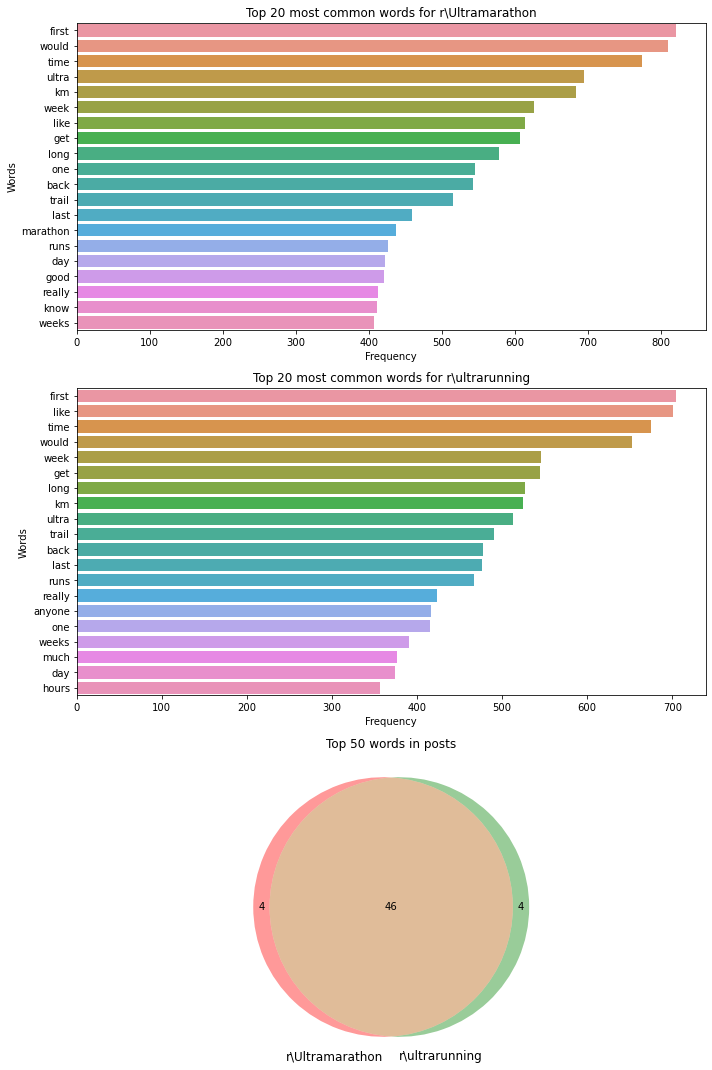

In [160]:
# Recap of common words between subreddits
frequentwords(df, 'cleaned_2', words_to_remove)

Out of the 50 most common words in the two subreddit communities, 46 intersect. Initially, I did not want to remove them as they may be constituents of useful bi-grams and tri-grams. I shall go aggressive now and remove all these intersection words to see if it could lead to better predictive models.

In [161]:
# Create function to analyse top 20 most frequently used words 
#   with defined stop-words dictionary 
def frequentwords(data, column_name = None, stopwords = None, n = 1):
    cvec = CountVectorizer(
        stop_words = stopwords,   # Default is no stop words
        ngram_range = (n,n)      # Default is to analyze 1-gram only
    )
    
    # Create word vector on subreddit1 
    vector1 = cvec.fit_transform(
        data.loc[
            data['subreddit'] == subreddit1,
            column_name
        ]
    )
    vector1_df = pd.DataFrame(
        vector1.todense(),
        columns = cvec.get_feature_names()
    ).sum(
    ).sort_values(
        ascending = False
    )
#     print(vector1_df)
    
    # Create word vector on subreddit2
    vector2 = cvec.fit_transform(
        data.loc[
            data['subreddit'] == subreddit2,
            column_name
        ]
    )
    vector2_df = pd.DataFrame(
        vector2.todense(),
        columns = cvec.get_feature_names()
    ).sum(
    ).sort_values(
        ascending = False
    )
#     print(vector2_df)
    
    # Prepare subplot area
    fig, axes = plt.subplots(figsize = (10,15), nrows = 3, ncols = 1)
    
    # Plot top 20 most common words
    ax1 = sns.barplot(
        x = vector1_df.head(20).values,
        y = vector1_df.head(20).index,
        orient = 'h',
        ax = axes[0]
    )
    ax1.set_title(f"Top 20 most common words for r\\{subreddit1}")
    ax1.set_xlabel("Frequency")
    ax1.set_ylabel("Words");
    
    ax2 = sns.barplot(
        x = vector2_df.head(20).values,
        y = vector2_df.head(20).index,
        orient = 'h',
        ax = axes[1]
    )
    ax2.set_title(f"Top 20 most common words for r\\{subreddit2}")
    ax2.set_xlabel("Frequency")
    ax2.set_ylabel("Words");
    
    # Plot Venn diagram to check intersection of 50 most common words
    ax3 = venn2(
        [
            set(vector1_df.head(50).index),
            set(vector2_df.head(50).index)
        ],
        set_labels = (f'r\\{subreddit1}', f'r\\{subreddit2}')
    )
    plt.title('Top 50 words in posts')
    plt.tight_layout()

#### Create custom function

In [162]:
def intersect_words(data, column_name, number_of_words = 50):
    cvec = CountVectorizer()
    
    # Create word vector on subreddit1 
    vector1 = cvec.fit_transform(
        data.loc[
            data['subreddit'] == subreddit1,
            column_name
        ]
    )
    vector1_df = pd.DataFrame(
        vector1.todense(),
        columns = cvec.get_feature_names()
    ).sum(
    ).sort_values(
        ascending = False
    ).head(number_of_words)

    # Create word vector on subreddit2
    vector2 = cvec.fit_transform(
        data.loc[
            data['subreddit'] == subreddit2,
            column_name
        ]
    )
    vector2_df = pd.DataFrame(
        vector2.todense(),
        columns = cvec.get_feature_names()
    ).sum(
    ).sort_values(
        ascending = False
    ).head(number_of_words)
    

    # Merge both dfs to get a df of intersection words
    unique_words = pd.merge(
        pd.DataFrame(vector1_df),
        pd.DataFrame(vector2_df),
        how='inner', 
        left_on = pd.DataFrame(vector1_df).index, 
        right_on = pd.DataFrame(vector2_df).index)

    print(list(unique_words['key_0'].ravel()))

#### Check intersection of 50 most common words

In [163]:
intersect_words(df, 'cleaned_lemma', 50)

['week', 'time', 'first', 'would', 'km', 'ultra', 'trail', 'day', 'get', 'year', 'like', 'hour', 'one', 'long', 'back', 'marathon', 'last', 'runner', 'know', 'run', 'good', 'really', 'distance', 'much', 'also', 'could', 'ran', 'anyone', 'plan', 'going', 'go', 'around', 'want', 'got', 'miler', 'next', 'way', 'feel', 'lot', 'thanks', 'month', 'think', 'looking', 'bit', 'started', 'foot']


#### Remove intersection words

In [164]:
# Round 3: Expand stop word dictionary
words_to_remove_new = words_to_remove + ['week', 'time', 'first', 'would', 'km', 'ultra', 'trail', 'day', 'get', 'year', 'like', 'hour', 'one', 'long', 'back', 'marathon', 'last', 'runner', 'know', 'run', 'good', 'really', 'distance', 'much', 'also', 'could', 'ran', 'anyone', 'plan', 'going', 'go', 'around', 'want', 'got', 'miler', 'next', 'way', 'feel', 'lot', 'thanks', 'month', 'think', 'looking', 'bit', 'started', 'foot']

In [165]:
words_to_remove_new[-50:]

['race',
 'training',
 'miles',
 'mile',
 'week',
 'time',
 'first',
 'would',
 'km',
 'ultra',
 'trail',
 'day',
 'get',
 'year',
 'like',
 'hour',
 'one',
 'long',
 'back',
 'marathon',
 'last',
 'runner',
 'know',
 'run',
 'good',
 'really',
 'distance',
 'much',
 'also',
 'could',
 'ran',
 'anyone',
 'plan',
 'going',
 'go',
 'around',
 'want',
 'got',
 'miler',
 'next',
 'way',
 'feel',
 'lot',
 'thanks',
 'month',
 'think',
 'looking',
 'bit',
 'started',
 'foot']

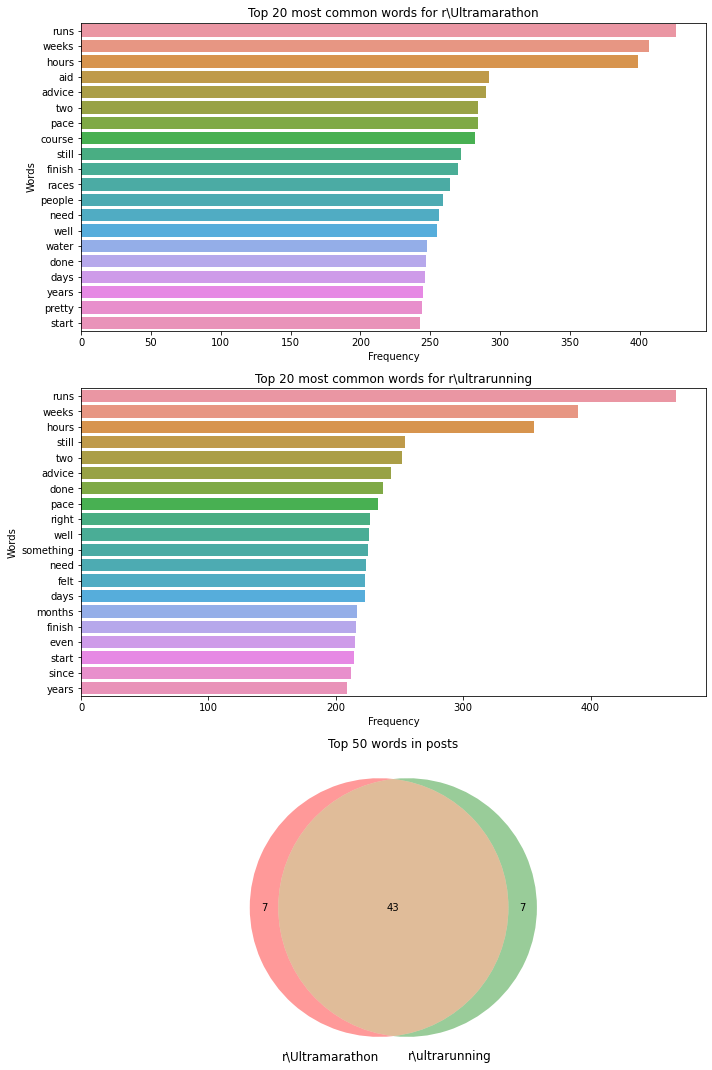

In [166]:
# Check most frequent words after additional stop words 
frequentwords(df, 'cleaned_2', words_to_remove_new)

The result is only marginally better after removing the first 46 most common intersecting words. I still end up with 43 intersecting words. Let's see if this makes Models 2 and 8 better, but I am not hopeful. I am facing a difficult enemy...

#### Create train test set

In [167]:
# Lemmatize after removing more stop words
lemmatizer = WordNetLemmatizer()

df['extreme_cleaned_lemma'] = df['cleaned_3'].map(
    lambda x: [lemmatizer.lemmatize(token) \
               for token in x \
               if token not in words_to_remove_new]
).map(
    lambda x: ' '.join(x)
)

In [168]:
# Create train test sets
X_extreme = df['extreme_cleaned_lemma']
y_extreme = df['target']

X_extreme_train, X_extreme_test, y_extreme_train, y_extreme_test = train_test_split(
    X_extreme, y_extreme,
    stratify = y_extreme,
    random_state = 42
)

In [169]:
# Check
X_extreme_train.shape, X_extreme_test.shape, y_extreme_train.shape, y_extreme_test.shape

((2227,), (743,), (2227,), (743,))

#### TfidfVectorizer / Multinomial

In [170]:
%%time
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# Set parameters
params = {
    'tvec__min_df': [1, 2],
    'tvec__max_df': [.1, .25, .5, 1],
    'tvec__max_features' : [500, 1000, 2000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'nb__alpha': [.25, .5, 1]
}

# Run pipe in GridSearchCV and print results
run_grid(X_extreme_train, X_extreme_test, y_extreme_train, y_extreme_test)

Mean CV score: 0.550
Best Parameters: {'nb__alpha': 0.25, 'tvec__max_df': 0.1, 'tvec__max_features': 2000, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 1)}
Train score: 0.810
Test score (aka Accuracy): 0.540
Sensitivity: 0.563, Specificity: 0.516, Precision: 0.537
CPU times: user 4.53 s, sys: 725 ms, total: 5.25 s
Wall time: 1min 22s


Can't work. Fail...the mean CV score and test score are worse than Model 2's.

#### TfidfVectorizer / ExtraTrees

In [171]:
%%time
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('et', ExtraTreesClassifier())
])

# Set parameters
params = {
    'tvec__min_df': [1],
    'tvec__max_df': [0.5],
    'tvec__max_features' : [500, 1000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'et__n_estimators': [100, 150, 200, 250, 300],
    'et__max_depth' : [None, 2, 4, 6, 8, 10]
}

# Run pipe in GridSearchCV and print results
run_grid(X_extreme_train, X_extreme_test, y_extreme_train, y_extreme_test)

Mean CV score: 0.542
Best Parameters: {'et__max_depth': 6, 'et__n_estimators': 300, 'tvec__max_df': 0.5, 'tvec__max_features': 500, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 1)}
Train score: 0.864
Test score (aka Accuracy): 0.525
Sensitivity: 0.447, Specificity: 0.602, Precision: 0.529
CPU times: user 4.47 s, sys: 609 ms, total: 5.07 s
Wall time: 2min 45s


This is a disaster, test score fails baseline score.

#### Update tracking table

| S/N | Word Vectorizer | Classifier | CV Score (train) | Accuracy (train) | Accuracy (test) | Sensitivity (test) | Specificity (test) | Precision (test) | Runtime | Remarks |
|-----|-----------------|------------|------------------|------------------|-----------------|--------------------|---------------------|------------------|---------|---------|
| 1 | Count | MultinomialNB | 0.558 | 0.652 | 0.545 | 0.485 | 0.605 | 0.550 | 1min 24s | Lemmatized |
| 2 | Tfidf | MultinomialNB | 0.564 | 0.675 | 0.540 | 0.526 | 0.554 | 0.540 | 1min 36s | Lemmatized |
| 3 | Count | Logistic | 0.552 | 0.783 | 0.529 | 0.531 | 0.527 | 0.528 | 1min 56s | Lemmatized |
| 4 | Tfidf | Logistic | 0.573 | 0.703 | 0.533 | 0.485 | 0.581 | 0.536 | 1min 48s | Lemmatized |
|||
| 5 | Count | RandomForest | 0.559 | 0.984 | 0.494 | 0.472 | 0.516 | 0.493 | 4min 6s | Lemmatized |
| 6 | Tfidf | RandomForest | 0.561 | 0.984 | 0.534 | 0.555 | 0.513 | 0.532 | 4min 34s | Lemmatized |
| 7 | Count | ExtraTrees | 0.558 | 0.752 | 0.529 | 0.385 | 0.672 | 0.540 | 4min 21s | Lemmatized |
| 8 | Tfidf | ExtraTrees | 0.561 | 0.797 | 0.542 | 0.464 | 0.621 | 0.550 | 4min 25s | Lemmatized |
|||
| 9 | Tfidf | MultinomialNB | 0.564 | 0.678 | 0.542 | 0.555 | 0.530 | 0.541 | 1min 37s | Stemmatized |
| 10 | Tfidf | ExtraTrees | 0.566 | 0.815 | 0.532 | 0.474 | 0.589 | 0.535 | 4min 14s | Stemmatized |
|||
| 11 | Tfidf | MultinomialNB | 0.560 | 0.686 | 0.524 | 0.543 | 0.504 | 0.523 | 1min 10s | Lemmatized, remove 46 intersection words |
| 12 | Tfidf | ExtraTrees | 0.551 | 0.858 | 0.489 | 0.578 | 0.399 | 0.491 | 2min 42s | Lemmatized, remove 46 intersection words |

It is a bad idea to remove intersection words from the top 50 most common words in the two subreddits. I am running out of options...this is a tough enemy to beat...

### Join Title to Selftext

One final attempt is to try to push beyond the project's remit of analyzing subreddit text only. I shall try to "create" more data by joining a post's title to its text, even though the title typically consists of much fewer words than its text. Perhaps I may be able to push accuracy beyond 0.60...

#### Clean title column

In [172]:
# Remove URLs
df['title_cleaned'] = df['title'].map(
    lambda x: re.sub(r'http\S+', '', x)
)

# Remove the %ampersand term
df['title_cleaned'] = df['title_cleaned'].map(
    lambda x: x.replace('&amp;#x200B;', ' ') 
)

# Extract words only    
df['title_cleaned'] = df['title_cleaned'].map(
    lambda x: re.sub('[^a-zA-Z]', ' ', x)
)

# Remove stop words and lemmatize
lemmatizer = WordNetLemmatizer()

df['title_cleaned'] = df['title_cleaned'].map(lambda x: x.lower().split())

df['title_cleaned'] = df['title_cleaned'].map(
    lambda x: [lemmatizer.lemmatize(token) \
               for token in x \
               if token not in words_to_remove
              ]
).map(
    lambda x: ' '.join(x)
)

In [173]:
df[['title', 'title_cleaned']].sample(5)

,title,title_cleaned
1229,Anyone else excited to see Rob Krar making a p...,anyone else excited see rob krar making possib...
316,Live AMA tomorrow on the ultrarunning discord ...,live ama tomorrow discord server brendan leona...
647,Marathon vs ultra recovery,marathon v ultra recovery
2525,Hydration pack chafing,hydration pack chafing
1098,Anyone use walking as a substitute for shorter...,anyone use walking substitute shorter run


In [174]:
df['title_cleaned'] + df['cleaned_lemma'], df['title_cleaned'], df['cleaned_lemma']

(0       mcm k salepurchased registration marine corp m...
 1       baseline mpw scheduledone couple ultras want b...
 2       spartathlonspartathlon km start tomorrow th ye...
 3       advice first ultrarunner finishing last cross ...
 4       better shapeneither person remotely close capa...
                               ...                        
 2965    anyone else struggle carb intakeknow science n...
 2966    minute per km increase decrease according dist...
 2967    first k yesterdayrace cancelled year including...
 2968    dan lawson new lejog fktearly hour morning dan...
 2969    think planhey seriously last year following kg...
 Length: 2970, dtype: object,
 0                                              mcm k sale
 1                                   baseline mpw schedule
 2                                             spartathlon
 3                                      advice first ultra
 4                                            better shape
                          

#### Create train test split

In [175]:
# Join lemmatized title to lemmatized selftext
#   then create train_test_split

X_joint = df['title_cleaned'] + df['cleaned_lemma']
y_joint = df['target']

X_joint_train, X_joint_test, y_joint_train, y_joint_test = train_test_split(
    X_joint, y_joint,
    stratify = y_joint,
    random_state = 42
)

In [176]:
# Check
X_joint_train.shape, X_joint_test.shape, y_joint_train.shape, y_joint_test.shape

((2227,), (743,), (2227,), (743,))

In [177]:
# Count new number of words

print(f"The original total word count is {df['word_count'].sum()}.")
print(f"Total word count after lemmatization is {np.sum([len(x.split()) for x in df['cleaned_lemma']])}.")
print(f"Total word count after combining title and selftext is {np.sum([len(x.split()) for x in df['title_cleaned'] + df['cleaned_lemma']])}.")

The original total word count is 442079.
Total word count after lemmatization is 203735.
Total word count after combining title and selftext is 213241.


In [178]:
211043 - 203806

7237

I gain another 7237 words to feed into my classification models. Not a lot, but worth something.

#### TfidfVectorizer / Multinomial

In [179]:
%%time
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# Set parameters
params = {
    'tvec__min_df': [1, 2],
    'tvec__max_df': [.1, .25, .5, 1],
    'tvec__max_features' : [500, 1000, 2000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'nb__alpha': [.25, .5, 1]
}

# Run pipe in GridSearchCV and print results
run_grid(X_joint_train, X_joint_test, y_joint_train, y_joint_test)

Mean CV score: 0.564
Best Parameters: {'nb__alpha': 0.25, 'tvec__max_df': 0.25, 'tvec__max_features': 500, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2)}
Train score: 0.673
Test score (aka Accuracy): 0.540
Sensitivity: 0.520, Specificity: 0.559, Precision: 0.541
CPU times: user 5.1 s, sys: 879 ms, total: 5.98 s
Wall time: 1min 39s


Performance matches closely to Model 2's. Mean CV score is lower, and test score is practically indistinguishable...

#### TfidfVectorizer / ExtraTrees

In [180]:
%%time
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('et', ExtraTreesClassifier())
])

# Set parameters
params = {
    'tvec__min_df': [1],
    'tvec__max_df': [0.5],
    'tvec__max_features' : [500, 1000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'et__n_estimators': [100, 150, 200, 250, 300],
    'et__max_depth' : [None, 2, 4, 6, 8, 10]
}

# Run pipe in GridSearchCV and print results
run_grid(X_joint_train, X_joint_test, y_joint_train, y_joint_test)

Mean CV score: 0.548
Best Parameters: {'et__max_depth': 10, 'et__n_estimators': 100, 'tvec__max_df': 0.5, 'tvec__max_features': 500, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 1)}
Train score: 0.903
Test score (aka Accuracy): 0.534
Sensitivity: 0.482, Specificity: 0.586, Precision: 0.538
CPU times: user 4.44 s, sys: 711 ms, total: 5.16 s
Wall time: 3min 2s


This is a disaster, CV score and test score are worse than its cousin Model 8.

#### Update tracking table

| S/N | Word Vectorizer | Classifier | CV Score (train) | Accuracy (train) | Accuracy (test) | Sensitivity (test) | Specificity (test) | Precision (test) | Runtime | Remarks |
|-----|-----------------|------------|------------------|------------------|-----------------|--------------------|---------------------|------------------|---------|---------|
| 1 | Count | MultinomialNB | 0.558 | 0.652 | 0.545 | 0.485 | 0.605 | 0.550 | 1min 24s | Lemmatized |
| 2 | Tfidf | MultinomialNB | 0.564 | 0.675 | 0.540 | 0.526 | 0.554 | 0.540 | 1min 36s | Lemmatized |
| 3 | Count | Logistic | 0.552 | 0.783 | 0.529 | 0.531 | 0.527 | 0.528 | 1min 56s | Lemmatized |
| 4 | Tfidf | Logistic | 0.573 | 0.703 | 0.533 | 0.485 | 0.581 | 0.536 | 1min 48s | Lemmatized |
|||
| 5 | Count | RandomForest | 0.559 | 0.984 | 0.494 | 0.472 | 0.516 | 0.493 | 4min 6s | Lemmatized |
| 6 | Tfidf | RandomForest | 0.561 | 0.984 | 0.534 | 0.555 | 0.513 | 0.532 | 4min 34s | Lemmatized |
| 7 | Count | ExtraTrees | 0.558 | 0.752 | 0.529 | 0.385 | 0.672 | 0.540 | 4min 21s | Lemmatized |
| 8 | Tfidf | ExtraTrees | 0.561 | 0.797 | 0.542 | 0.464 | 0.621 | 0.550 | 4min 25s | Lemmatized |
|||
| 9 | Tfidf | MultinomialNB | 0.564 | 0.678 | 0.542 | 0.555 | 0.530 | 0.541 | 1min 37s | Stemmatized |
| 10 | Tfidf | ExtraTrees | 0.566 | 0.815 | 0.532 | 0.474 | 0.589 | 0.535 | 4min 14s | Stemmatized |
|||
| 11 | Tfidf | MultinomialNB | 0.560 | 0.686 | 0.524 | 0.543 | 0.504 | 0.523 | 1min 10s | Lemmatized, remove 46 intersection words |
| 12 | Tfidf | ExtraTrees | 0.551 | 0.858 | 0.489 | 0.578 | 0.399 | 0.491 | 2min 42s | Lemmatized, remove 46 intersection words |
|||
| 13 | Tfidf | MultinomialNB | 0.558 | 0.688 | 0.541 | 0.554 | 0.528 | 0.541 | 1min 22s | Lemmatized, title + selftext |
| 14 | Tfidf | ExtraTrees | 0.549 | 0.928 | 0.515 | 0.532 | 0.499 | 0.516 | 3min 5s | Lemmatized, title + selftext |

## Conclusion

I tried my best but it is extremely hard to squeeze out more performance from standard classification models to predict a post's likelihood of being in r\Ultramarathon or r\ultrarunning. To recap, I tried a total of 14 models (16, if you include my ill-fated attempt to limit word vectorizers to bigrams and trigrams only), but I am unable to raise test accuracy to go beyond **55%**. The baseline score is **50.1%**. 

The "best" overall model is to use lemmatization + Term Frequency - Inverse Document Frequency (TF-IDF) Vectorizer + a multinomial naive Bayes classifier trained on post content. I tried a couple of variations, namely using stem words, removal of words with high level of intersection between sets of common words in r\Ultramarathon and r\ultrarunning, and even a desperate attempt to combine words in the title to the post's content.  Unfortunately, these attempts were unable to induce a material improvement in predictive ability.

My conclusion is that I have inadvertently picked two extremely similar subreddits to tackle. Perhaps, as author 05778 wrote in one of his posts (see below), **"Why Not Kill This Subreddit?	And merge it with r/ultrarunning?**. I have no choice but to agree with him wholeheartedly!

In [181]:
df.loc[df['author'] == '05778', ['subreddit','author','title','cleaned_1']]

,subreddit,author,title,cleaned_1
54,Ultramarathon,05778,UTMB 2022 Dates,Does anybody know the the dates for UTMB in 20...
661,Ultramarathon,05778,Poles on an Airplane?,Had anyone ever taken their trekking/running p...
961,Ultramarathon,05778,Why Not Kill This Subreddit?,And merge it with r/ultrarunning?
1629,ultrarunning,05778,Maybe The Top American Men Should Just Finish ...,Instead of quitting as soon as the chance of w...
2914,ultrarunning,05778,UTMB Points 2021,With so few races in 2020 will UTMB alter thei...
